In [1]:
import gensim
from scipy import stats
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import ParameterGrid
from nltk.corpus import wordnet as wn
import gensim.downloader

## Gold Standard Data Loading

In [2]:
sl = pd.read_csv('wordsim_relatedness_goldstandard.txt', sep='\t')
sl.columns = ['word_1', 'word_2', 'score']
sl = sl[:100]
ls = pd.DataFrame(data=sl, columns=['word_1', 'word_2'])
ls = ls[['word_2', 'word_1']]
ls = ls.rename(columns={"word_1": "word_2", "word_2": "word_1"})

In [3]:
sl = pd.concat([sl,ls], axis=0).reset_index(drop=True).drop([3, 9, 10, 12, 17, 99, 43, 103, 109, 110, 112, 117, 143, 168, 199, 68, 
                                              161, 61]).reset_index(drop=True)

## Human data loading and processing

In [4]:
df = pd.read_csv('data_tutorial_2021-01-18.csv',encoding='utf16', sep='\t')
df = df.drop(columns=['CASE', 'SERIAL', 'REF', 'QUESTNNR', 'MODE', 'STARTED', 'MAILSENT'])
df.columns = df.iloc[0]
df = df.dropna().reset_index(drop=True).drop([4, 0]).reset_index(drop=True)
df = df.iloc[:, :200]
df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce', axis=1)
df.iloc[:, 2:] = df.iloc[:, 2:] - 1
df.iloc[7, 1] = 22
df.iloc[9, 0] = 'Russian'
df.iloc[10, 0] = 'Russian'
df.iloc[14, 0] = 'Russian'
# df.loc[17] = df.iloc[:, 2:101].mean()
# df.loc[18] = df.iloc[:, 101:].mean()
# df.iloc[17, 101:] = df.iloc[17, 2:101].values
# df.iloc[18, 2:101] = df.iloc[18, 101:].values
# df.loc[19] = df.loc[17] - df.loc[18] # W1W2 - W2W1
a = [3, 9, 10, 12, 17, 43, 103, 109, 110, 112, 117, 143, 168, 68, 161, 61]
df.drop(df.columns[[b + 2 for b in a]], axis = 1, inplace=True)
df

,Native language: [01],Age: [01],Pairs 1: Jerusalem\tIsrael,Pairs 1: planet\tgalaxy,Pairs 1: canyon\tlandscape,Pairs 1: day\tsummer,Pairs 1: day\tdawn,Pairs 1: country\tcitizen,Pairs 1: planet\tpeople,Pairs 1: environment\tecology,...,Pairs 2: emergency\tvictim,Pairs 2: car\tluxury,Pairs 2: implement\ttool,Pairs 2: price\tcompetition,Pairs 2: doctor\tpsychology,Pairs 2: equality\tgender,Pairs 2: category\tlisting,Pairs 2: archive\tvideo,Pairs 2: stock\toil,Pairs 2: office\tgovernor
0,Korean,28,9,9,9,6,2,9,5,8,...,7,9,9,9,7,6,9,8,8,9
1,Chinese,24,9,8,5,3,2,6,5,9,...,5,5,2,3,6,6,7,6,3,7
2,Arabic,30,0,6,4,1,6,8,8,7,...,7,7,6,7,5,8,3,3,6,6
3,Russian,28,4,2,3,4,3,3,0,4,...,0,2,2,3,3,2,3,1,1,1
4,Russian,23,8,6,8,5,1,8,6,9,...,2,6,6,8,5,8,7,8,2,5
5,Russian,23,5,4,5,6,10,10,4,5,...,7,4,0,3,5,5,10,5,4,5
6,Russian,19,8,10,10,8,8,10,8,9,...,10,10,5,10,10,8,5,10,6,8
7,Indonesian,22,5,10,10,5,4,10,2,10,...,0,5,10,0,10,10,5,0,0,5
8,Russian,15,10,9,7,4,1,8,7,10,...,0,7,3,8,9,9,5,7,1,5
9,Russian,50,9,9,9,7,9,2,8,8,...,3,9,2,2,10,5,7,8,8,7


#### Distribution of human answers for each pair of words

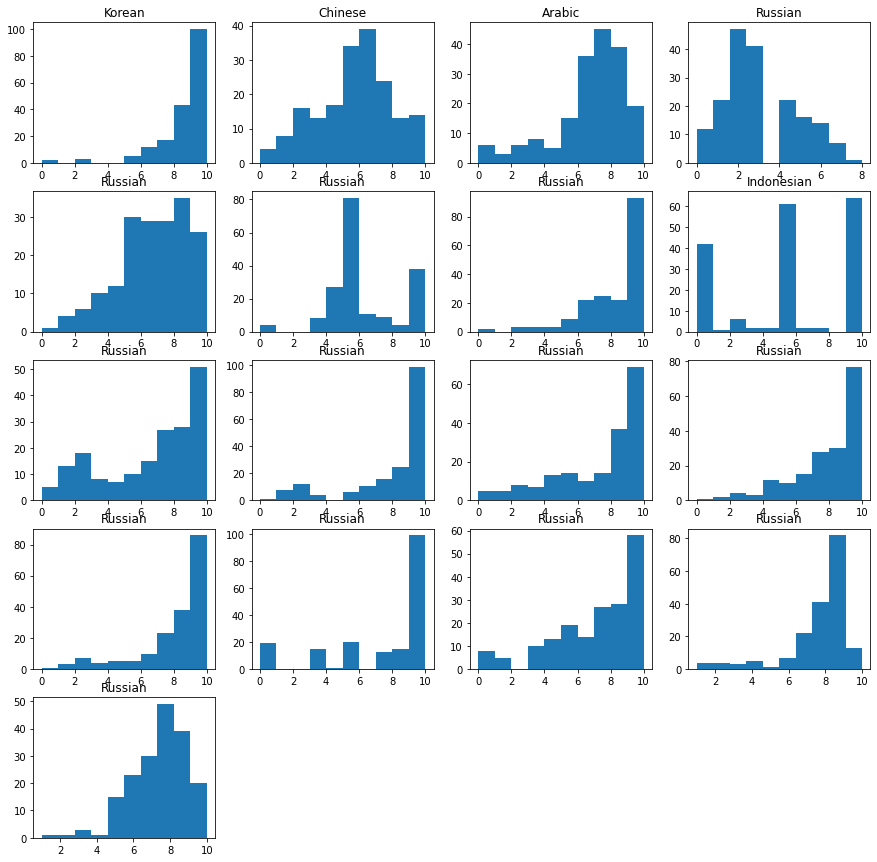

In [5]:
plt.figure(figsize=(15,15))
for i in range(1, 18):
    plt.subplot(5, 4, i)
    plt.hist(df.iloc[i-1, 2:])
    plt.title(df.iloc[i-1, 0])

Text(0.5, 0, 'Sem. Sim. Score')

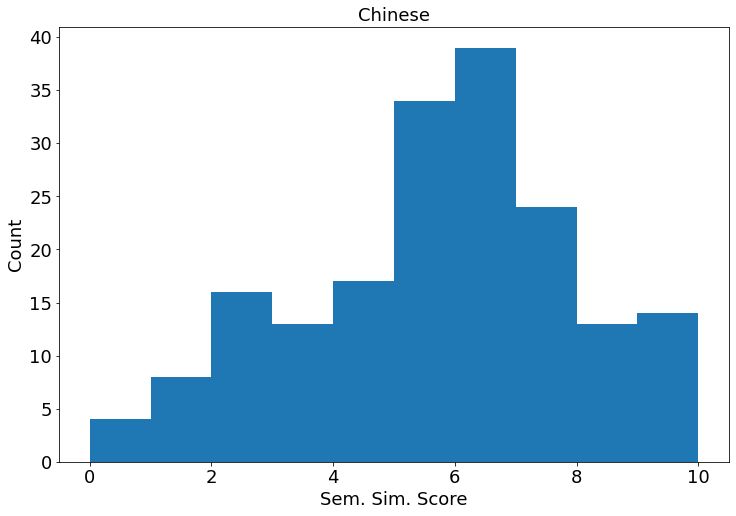

In [6]:
# Plotting only one points distribution
plt.figure(figsize=(12,8))
plt.hist(df.iloc[1, 2:])
plt.title(df.iloc[1, 0], fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Sem. Sim. Score', fontsize=18)

In [7]:
df_full = pd.DataFrame(sl[0:91].drop(columns=['score']).reset_index(drop=True))
df_full['gs'] = sl['score'][0:91]
df_full['normal_average'] = df.iloc[:, 2:93].mean().reset_index(drop=True)
df_full['reversed_average'] = df.iloc[:, 93:].mean().reset_index(drop=True)
df_full['na-gs'] = df_full['normal_average'] - df_full['gs']
df_full

,word_1,word_2,gs,normal_average,reversed_average,na-gs
0,Jerusalem,Israel,8.46,7.647059,7.647059,-0.812941
1,planet,galaxy,8.11,8.058824,8.176471,-0.051176
2,canyon,landscape,7.53,7.764706,7.764706,0.234706
3,day,summer,3.94,4.882353,5.647059,0.942353
4,day,dawn,7.53,5.235294,4.882353,-2.294706
...,...,...,...,...,...,...
86,gender,equality,6.41,6.647059,6.647059,0.237059
87,listing,category,6.38,5.294118,6.294118,-1.085882
88,video,archive,6.34,5.294118,5.529412,-1.045882
89,oil,stock,6.34,4.058824,4.941176,-2.281176


#### Plotting the Human Data and the Gold Standard Data

(array([3., 4., 5., 6., 7., 8., 9.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

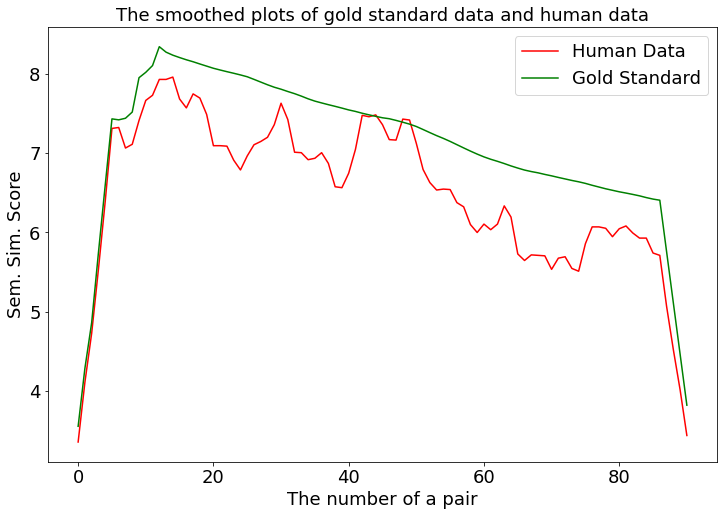

In [8]:
x = [x for x in range(91)]
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
plt.figure(figsize=(12,8))
plt.plot(x, smooth(df_full['normal_average'], 10), color='red')
plt.plot(x, smooth(df_full['gs'], 10), color='green')
plt.xlabel('The number of a pair', fontsize=18)
plt.ylabel('Sem. Sim. Score', fontsize=18)
plt.legend(['Human Data', 'Gold Standard'], fontsize=18)
plt.title('The smoothed plots of gold standard data and human data', fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
#plt.plot(x, df_out.iloc[21, 2:93], color='blue')

#### Computing correlation and t-test

In [9]:
df_full.corr()

,gs,normal_average,reversed_average,na-gs
gs,1.000000,0.536647,0.463586,-0.038245
normal_average,0.536647,1.000000,0.924622,0.822666
reversed_average,0.463586,0.924622,1.000000,0.782625
na-gs,-0.038245,0.822666,0.782625,1.000000


In [10]:
stats.ttest_ind(df_full['normal_average'], df_full['gs'])

Ttest_indResult(statistic=-3.8451521883740085, pvalue=0.0001669997048643289)

#### Creating a dataset with normal, reversed_pairs, and human average score

In [11]:
#data = pd.DataFrame(sl.drop(columns=['score']))
#data['human_average'] = pd.concat([df_full['normal_average'], df_full['reversed_average']], axis=1, ignore_index=True)
data= pd.DataFrame(data = 
                   pd.concat([df_full['normal_average'], df_full['reversed_average']], axis=0, ignore_index=True),
                  columns=
                  ['human_average'])
data['word_1'] = sl['word_1']
data['word_2'] = sl['word_2']
data=data[['word_1', 'word_2', 'human_average']]


In [12]:
data

,word_1,word_2,human_average
0,Jerusalem,Israel,7.647059
1,planet,galaxy,8.058824
2,canyon,landscape,7.764706
3,day,summer,4.882353
4,day,dawn,5.235294
...,...,...,...
177,equality,gender,6.647059
178,category,listing,6.294118
179,archive,video,5.529412
180,stock,oil,4.941176


# Models

### 250k_glec_sg500 model

In [13]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('250k_glec_sg500.vec')

### Path similarity and correlation

In [14]:
def SimScore_path(synsets1, synsets2):
    
    '''
    Purpose: Computes sentence similarity using Wordnet path_similarity().
    Input: Synset lists representing sentence 1 and sentence 2.
    Output: Similarity score as a float
    '''
 
#     print("-----")
#     print("Synsets1: %s\n" % synsets1)
#     print("Synsets2: %s\n" % synsets2)

    sumSimilarityscores = 0
    scoreCount = 0

    # For each synset in the first sentence...
    for synset1 in synsets1:

        synsetScore = 0
        similarityScores = []

        # For each synset in the second sentence...
        for synset2 in synsets2:

            # Only compare synsets with the same POS tag. Word to word knowledge
            # measures cannot be applied across different POS tags.
            if synset1.pos() == synset2.pos():

                # Note below is the call to path_similarity mentioned above. 
                synsetScore = synset1.path_similarity(synset2)

                if synsetScore != None:
                    #print("Path Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                # If there are no similarity results but the SAME WORD is being
                # compared then it gives a max score of 1.
                elif synset1.name().split(".")[0] == synset2.name().split(".")[0]:
                    synsetScore = 1
                    #print("Path MAX-Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                synsetScore = 0

        if(len(similarityScores) > 0):
            sumSimilarityscores += max(similarityScores)
            scoreCount += 1

    # Average the summed, maximum similarity scored and return.
    if scoreCount > 0:
        avgScores = sumSimilarityscores / scoreCount

    #print("Func Score: %0.2f" % avgScores)
    return(avgScores)

In [15]:
# Test
s1 = wn.synsets('cat')
s2 = wn.synsets('kitty')
s1[0].path_similarity(s2[0])

0.043478260869565216

In [17]:
def SimScore_lch(synsets1, synsets2):
    
    '''
    Purpose: Computes sentence similarity using Wordnet path_similarity().
    Input: Synset lists representing sentence 1 and sentence 2.
    Output: Similarity score as a float
    '''
 
#     print("-----")
#     print("Synsets1: %s\n" % synsets1)
#     print("Synsets2: %s\n" % synsets2)

    sumSimilarityscores = 0
    scoreCount = 0

    # For each synset in the first sentence...
    for synset1 in synsets1:

        synsetScore = 0
        similarityScores = []

        # For each synset in the second sentence...
        for synset2 in synsets2:

            # Only compare synsets with the same POS tag. Word to word knowledge
            # measures cannot be applied across different POS tags.
            if synset1.pos() == synset2.pos():

                # Note below is the call to path_similarity mentioned above. 
                synsetScore = synset1.lch_similarity(synset2)

                if synsetScore != None:
                    #print("Path Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                # If there are no similarity results but the SAME WORD is being
                # compared then it gives a max score of 1.
                elif synset1.name().split(".")[0] == synset2.name().split(".")[0]:
                    synsetScore = 1
                    #print("Path MAX-Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                synsetScore = 0

        if(len(similarityScores) > 0):
            sumSimilarityscores += max(similarityScores)
            scoreCount += 1

    # Average the summed, maximum similarity scored and return.
    if scoreCount > 0:
        avgScores = sumSimilarityscores / scoreCount

    #print("Func Score: %0.2f" % avgScores)
    return(avgScores)

In [18]:
def SimScore_wup(synsets1, synsets2):
    
    '''
    Purpose: Computes sentence similarity using Wordnet path_similarity().
    Input: Synset lists representing sentence 1 and sentence 2.
    Output: Similarity score as a float
    '''
 
#     print("-----")
#     print("Synsets1: %s\n" % synsets1)
#     print("Synsets2: %s\n" % synsets2)

    sumSimilarityscores = 0
    scoreCount = 0

    # For each synset in the first sentence...
    for synset1 in synsets1:

        synsetScore = 0
        similarityScores = []

        # For each synset in the second sentence...
        for synset2 in synsets2:

            # Only compare synsets with the same POS tag. Word to word knowledge
            # measures cannot be applied across different POS tags.
            if synset1.pos() == synset2.pos():

                # Note below is the call to path_similarity mentioned above. 
                synsetScore = synset1.wup_similarity(synset2)

                if synsetScore != None:
                    #print("Path Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                # If there are no similarity results but the SAME WORD is being
                # compared then it gives a max score of 1.
                elif synset1.name().split(".")[0] == synset2.name().split(".")[0]:
                    synsetScore = 1
                    #print("Path MAX-Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                synsetScore = 0

        if(len(similarityScores) > 0):
            sumSimilarityscores += max(similarityScores)
            scoreCount += 1

    # Average the summed, maximum similarity scored and return.
    if scoreCount > 0:
        avgScores = sumSimilarityscores / scoreCount

    #print("Func Score: %0.2f" % avgScores)
    return(avgScores)

In [19]:
def use_the_model(data, topn=10, a=0.2, b=0.8):
    outcome = pd.DataFrame()
    for i in range(len(data)):
        w1 = data.word_1.values[i]
        w2 = data.word_2.values[i]
        
        
        df1 = pd.DataFrame(model.most_similar(w1, topn=topn),columns = ['word','sim'])
        df2 = pd.DataFrame(model.most_similar(w2, topn=topn),columns = ['word','sim'])
        
        #Now path_sim
        s1 = wn.synsets(w1)
        s2 = wn.synsets(w2)
    
        d1 = df1.sim.mean()
        d2 = df2.sim.mean()
        outcome = outcome.append({'word_1': w1, 
            'word_2': w2,
            'Symsim': model.similarity(w1, w2),
            'Asymsim_w1w2': model.similarity(w1,w2) + df1.sim.mean()*a + df2.sim.mean()*b,
            'Asymsim_w2w1': model.similarity(w1,w2) + df2.sim.mean()*a + df1.sim.mean()*b,
            'Path_sim': SimScore_path(s1, s2),
            'Lch_sim': SimScore_lch(s1, s2),
            'Wup_sim': SimScore_wup(s1, s2)                     },
                       ignore_index=True)
    return outcome


In [20]:
# Use the models with the default parameters topn=10, a=0.2, b=0.8
use_the_model(data)

,Asymsim_w1w2,Asymsim_w2w1,Lch_sim,Path_sim,Symsim,Wup_sim,word_1,word_2
0,0.823940,0.849389,1.691676,0.142857,0.396574,0.700000,Jerusalem,Israel
1,0.633711,0.700737,1.409382,0.108333,0.276625,0.524252,planet,galaxy
2,0.710861,0.748952,1.152680,0.083333,0.214070,0.352941,canyon,landscape
3,0.944671,0.892835,1.822384,0.174597,0.377456,0.580513,day,summer
4,0.829265,0.784228,2.016714,0.217424,0.271115,0.627406,day,dawn
...,...,...,...,...,...,...,...,...
177,0.355173,0.430665,1.558145,0.125000,0.014538,0.461538,equality,gender
178,0.259738,0.267437,1.340026,0.101010,-0.030766,0.354167,category,listing
179,0.802284,0.668553,1.440362,0.111111,0.168889,0.555556,archive,video
180,0.679669,0.634724,1.212121,0.104434,0.194534,0.353017,stock,oil


In [21]:
# This function performs parameters grid search and prints in the end the best combination of the params and
# the correlations score for the 250k_glec_sg500 model.

def parameters_est(data, model_func):
    param_grid = {'topn': [1, 10, 50, 100, 500, 1000], 
              'a' : np.arange(0, 1.1, 0.1),
              'b' : np.arange(0, 1.1, 0.1)
#                   'a':[0.1, 0.5, 1.0],
#                   'b':[0.1, 0.5, 1.0]
                 }
    grid = ParameterGrid(param_grid)
    
    scores = []
    for params in grid:
        c = correlation(data, model_func(data, params['topn'], params['a'], params['b']))
        print(c)
        params['corr_score'] = c.iloc[0, 2]
        print('Parameters:', params)
        scores.append(params)

    return max(scores, key=lambda x:x['corr_score'])

def correlation(data, model_data):
    cor_df = pd.DataFrame()
    cor_df['human_average'] = data['human_average'].astype(float)
    cor_df['Symsim'] = model_data['Symsim']
    cor_df['Asymsim'] = model_data['Asymsim_w1w2']
    cor_df['Path_sim'] = model_data['Path_sim']
    cor_df['Lch_sim'] = model_data['Lch_sim']
    cor_df['Wup_sim'] = model_data['Wup_sim']
    return cor_df.corr(method='pearson')

In [41]:
parameters_est(data, use_the_model)

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.267011  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  1.000000  0.418471  0.405654  0.413808
Asymsim             0.267011  1.000000  1.000000  0.418471  0.405654  0.413808
Path_sim            0.045185  0.418471  0.418471  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.405654  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.413808  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.0, 'topn': 1, 'corr_score': 0.26701090193387667}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.267011  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  1.000000  0.418471  0.405654  0.413808
Asymsim             0.267011  1.000000  1.000000  0.418471  0.405654  0.413808
Path_sim            0.045185  0.418471  0.418471  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.275400  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.992912  0.418471  0.405654  0.413808
Asymsim             0.275400  0.992912  1.000000  0.396682  0.382023  0.389518
Path_sim            0.045185  0.418471  0.396682  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.382023  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.389518  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.2, 'topn': 10, 'corr_score': 0.2754004013403692}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.272013  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.995669  0.418471  0.405654  0.413808
Asymsim             0.272013  0.995669  1.000000  0.399789  0.385151  0.394276
Path_sim            0.045185  0.418471  0.399789  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.274587  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.983526  0.418471  0.405654  0.413808
Asymsim             0.274587  0.983526  1.000000  0.378776  0.362521  0.372498
Path_sim            0.045185  0.418471  0.378776  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.362521  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.372498  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.4, 'topn': 50, 'corr_score': 0.27458689510803697}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.271792  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.986468  0.418471  0.405654  0.413808
Asymsim             0.271792  0.986468  1.000000  0.383129  0.367002  0.377761
Path_sim            0.045185  0.418471  0.383129  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.271510  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.971034  0.418471  0.405654  0.413808
Asymsim             0.271510  0.971034  1.000000  0.363096  0.345573  0.357448
Path_sim            0.045185  0.418471  0.363096  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.345573  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.357448  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.6000000000000001, 'topn': 100, 'corr_score': 0.27150977628891193}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.262184  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.979131  0.418471  0.405654  0.413808
Asymsim             0.262184  0.979131  1.000000  0.376647  0.359545  0.374306
Path_sim            0.045185  0.418

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.258441  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.964265  0.418471  0.405654  0.413808
Asymsim             0.258441  0.964265  1.000000  0.360378  0.342085  0.358782
Path_sim            0.045185  0.418471  0.360378  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.342085  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.358782  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.8, 'topn': 500, 'corr_score': 0.25844098691884015}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.255089  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.966915  0.418471  0.405654  0.413808
Asymsim             0.255089  0.966915  1.000000  0.366476  0.348367  0.366658
Path_sim            0.045185  0.418471  0.366476  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.249920  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.950130  0.418471  0.405654  0.413808
Asymsim             0.249920  0.950130  1.000000  0.350964  0.331799  0.352268
Path_sim            0.045185  0.418471  0.350964  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.331799  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.352268  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 1.0, 'topn': 1000, 'corr_score': 0.24992018653511033}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.272187  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.996709  0.418471  0.405654  0.413808
Asymsim             0.272187  0.996709  1.000000  0.411875  0.400356  0.405909
Path_sim            0.045185  0.418471  0.411875 

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.281401  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.983828  0.418471  0.405654  0.413808
Asymsim             0.281401  0.983828  1.000000  0.395682  0.383827  0.382394
Path_sim            0.045185  0.418471  0.395682  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.383827  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.382394  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.2, 'topn': 1, 'corr_score': 0.2814011320252741}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.277625  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.990162  0.418471  0.405654  0.413808
Asymsim             0.277625  0.990162  1.000000  0.387011  0.372301  0.379349
Path_sim            0.045185  0.418471  0.387011  1.0

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.281556  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.970515  0.418471  0.405654  0.413808
Asymsim             0.281556  0.970515  1.000000  0.362119  0.345917  0.352279
Path_sim            0.045185  0.418471  0.362119  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.345917  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.352279  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.4, 'topn': 10, 'corr_score': 0.28155589127255987}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.275580  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.980948  0.418471  0.405654  0.413808
Asymsim             0.275580  0.980948  1.000000  0.370708  0.354279  0.364340
Path_sim            0.045185  0.418471  0.370708  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.275818  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.962161  0.418471  0.405654  0.413808
Asymsim             0.275818  0.962161  1.000000  0.348538  0.330738  0.341511
Path_sim            0.045185  0.418471  0.348538  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.330738  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.341511  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.6000000000000001, 'topn': 50, 'corr_score': 0.27581777180582095}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.271766  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.968235  0.418471  0.405654  0.413808
Asymsim             0.271766  0.968235  1.000000  0.355930  0.338251  0.350245
Path_sim            0.045185  0.4184

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.269909  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.948294  0.418471  0.405654  0.413808
Asymsim             0.269909  0.948294  1.000000  0.335402  0.316532  0.329491
Path_sim            0.045185  0.418471  0.335402  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.316532  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.329491  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.8, 'topn': 100, 'corr_score': 0.26990946051846115}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.257173  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.961371  0.418471  0.405654  0.413808
Asymsim             0.257173  0.961371  1.000000  0.354937  0.336529  0.353621
Path_sim            0.045185  0.418471  0.354937  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.252572  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.943305  0.418471  0.405654  0.413808
Asymsim             0.252572  0.943305  1.000000  0.338160  0.318705  0.337549
Path_sim            0.045185  0.418471  0.338160  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.318705  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.337549  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 1.0, 'topn': 500, 'corr_score': 0.2525723667982013}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.248202  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.946940  0.418471  0.405654  0.413808
Asymsim             0.248202  0.946940  1.000000  0.346104  0.326848  0.347850
Path_sim            0.045185  0.418471  0.346104  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.263774  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.996515  0.418471  0.405654  0.413808
Asymsim             0.263774  0.996515  1.000000  0.403904  0.390019  0.400856
Path_sim            0.045185  0.418471  0.403904  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.390019  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.400856  0.769559  0.893571  1.000000
Parameters: {'a': 0.2, 'b': 0.1, 'topn': 1000, 'corr_score': 0.2637739755403743}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.284181  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.974881  0.418471  0.405654  0.413808
Asymsim             0.284181  0.974881  1.000000  0.387480  0.376890  0.373224
Path_sim            0.045185  0.418471  0.387480  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.286498  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.944701  0.418471  0.405654  0.413808
Asymsim             0.286498  0.944701  1.000000  0.365997  0.355271  0.345663
Path_sim            0.045185  0.418471  0.365997  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.355271  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.345663  0.769559  0.893571  1.000000
Parameters: {'a': 0.2, 'b': 0.4, 'topn': 1, 'corr_score': 0.2864975346320053}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.282516  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.964573  0.418471  0.405654  0.413808
Asymsim             0.282516  0.964573  1.000000  0.352096  0.335926  0.341858
Path_sim            0.045185  0.418471  0.352096  1.0

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.283022  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.937015  0.418471  0.405654  0.413808
Asymsim             0.283022  0.937015  1.000000  0.326454  0.309115  0.314386
Path_sim            0.045185  0.418471  0.326454  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.309115  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.314386  0.769559  0.893571  1.000000
Parameters: {'a': 0.2, 'b': 0.6000000000000001, 'topn': 10, 'corr_score': 0.28302249936630985}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.276092  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.957608  0.418471  0.405654  0.413808
Asymsim             0.276092  0.957608  1.000000  0.340308  0.322400  0.333220
Path_sim            0.045185  0.4184

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.274539  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.934425  0.418471  0.405654  0.413808
Asymsim             0.274539  0.934425  1.000000  0.318082  0.299036  0.310436
Path_sim            0.045185  0.418471  0.318082  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.299036  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.310436  0.769559  0.893571  1.000000
Parameters: {'a': 0.2, 'b': 0.8, 'topn': 50, 'corr_score': 0.27453853603067246}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.269652  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.944004  0.418471  0.405654  0.413808
Asymsim             0.269652  0.944004  1.000000  0.328153  0.309181  0.322219
Path_sim            0.045185  0.418471  0.328153  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.266635  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.921158  0.418471  0.405654  0.413808
Asymsim             0.266635  0.921158  1.000000  0.307862  0.287887  0.301749
Path_sim            0.045185  0.418471  0.307862  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.287887  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.301749  0.769559  0.893571  1.000000
Parameters: {'a': 0.2, 'b': 1.0, 'topn': 100, 'corr_score': 0.2666345560535973}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.251012  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.939250  0.418471  0.405654  0.413808
Asymsim             0.251012  0.939250  1.000000  0.332543  0.313014  0.332197
Path_sim            0.045185  0.418471  0.332543  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.263692  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.992867  0.418471  0.405654  0.413808
Asymsim             0.263692  0.992867  1.000000  0.395611  0.381511  0.392261
Path_sim            0.045185  0.418471  0.395611  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.381511  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.392261  0.769559  0.893571  1.000000
Parameters: {'a': 0.30000000000000004, 'b': 0.1, 'topn': 500, 'corr_score': 0.2636924717091648}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.262021  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.993450  0.418471  0.405654  0.413808
Asymsim             0.262021  0.993450  1.000000  0.398649  0.384626  0.396097
Path_sim            0.045185  0.418

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.259592  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.987183  0.418471  0.405654  0.413808
Asymsim             0.259592  0.987183  1.000000  0.386431  0.371037  0.385088
Path_sim            0.045185  0.418471  0.386431  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.371037  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.385088  0.769559  0.893571  1.000000
Parameters: {'a': 0.30000000000000004, 'b': 0.30000000000000004, 'topn': 1000, 'corr_score': 0.25959193230416994}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.287677  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.933324  0.418471  0.405654  0.413808
Asymsim             0.287677  0.933324  1.000000  0.357595  0.348045  0.336627
Path_sim         

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.285584  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.895327  0.418471  0.405654  0.413808
Asymsim             0.285584  0.895327  1.000000  0.334828  0.325229  0.309018
Path_sim            0.045185  0.418471  0.334828  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.325229  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.309018  0.769559  0.893571  1.000000
Parameters: {'a': 0.30000000000000004, 'b': 0.6000000000000001, 'topn': 1, 'corr_score': 0.2855843632257186}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.283082  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.929303  0.418471  0.405654  0.413808
Asymsim             0.283082  0.929303  1.000000  0.316721  0.299481  0.304352
Path_sim            0.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.281257  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.897862  0.418471  0.405654  0.413808
Asymsim             0.281257  0.897862  1.000000  0.291977  0.273838  0.278104
Path_sim            0.045185  0.418471  0.291977  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.273838  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.278104  0.769559  0.893571  1.000000
Parameters: {'a': 0.30000000000000004, 'b': 0.8, 'topn': 10, 'corr_score': 0.2812569653187932}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.274275  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.928601  0.418471  0.405654  0.413808
Asymsim             0.274275  0.928601  1.000000  0.310013  0.290917  0.302332
Path_sim            0.045185  0.4184

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.271462  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.902979  0.418471  0.405654  0.413808
Asymsim             0.271462  0.902979  1.000000  0.288528  0.268498  0.280382
Path_sim            0.045185  0.418471  0.288528  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.268498  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.280382  0.769559  0.893571  1.000000
Parameters: {'a': 0.30000000000000004, 'b': 1.0, 'topn': 50, 'corr_score': 0.2714619736563708}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.265998  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.915885  0.418471  0.405654  0.413808
Asymsim             0.265998  0.915885  1.000000  0.300752  0.280724  0.294631
Path_sim            0.045185  0.4184

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.269447  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.984105  0.418471  0.405654  0.413808
Asymsim             0.269447  0.984105  1.000000  0.378116  0.363653  0.373085
Path_sim            0.045185  0.418471  0.378116  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.363653  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.373085  0.769559  0.893571  1.000000
Parameters: {'a': 0.4, 'b': 0.1, 'topn': 100, 'corr_score': 0.2694467213441413}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.262015  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.988450  0.418471  0.405654  0.413808
Asymsim             0.262015  0.988450  1.000000  0.389215  0.374983  0.386172
Path_sim            0.045185  0.418471  0.389215  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.260364  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.981236  0.418471  0.405654  0.413808
Asymsim             0.260364  0.981236  1.000000  0.375535  0.359904  0.373244
Path_sim            0.045185  0.418471  0.375535  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.359904  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.373244  0.769559  0.893571  1.000000
Parameters: {'a': 0.4, 'b': 0.30000000000000004, 'topn': 500, 'corr_score': 0.260364422342256}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.257461  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.982579  0.418471  0.405654  0.413808
Asymsim             0.257461  0.982579  1.000000  0.380721  0.365225  0.379858
Path_sim            0.045185  0.4184

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.253951  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.972049  0.418471  0.405654  0.413808
Asymsim             0.253951  0.972049  1.000000  0.367218  0.350469  0.367524
Path_sim            0.045185  0.418471  0.367218  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.350469  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.367524  0.769559  0.893571  1.000000
Parameters: {'a': 0.4, 'b': 0.5, 'topn': 1000, 'corr_score': 0.2539507196256261}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.285867  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.883709  0.418471  0.405654  0.413808
Asymsim             0.285867  0.883709  1.000000  0.327041  0.318507  0.300864
Path_sim            0.045185  0.418471  0.327041  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.281396  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.844182  0.418471  0.405654  0.413808
Asymsim             0.281396  0.844182  1.000000  0.305317  0.296756  0.275343
Path_sim            0.045185  0.418471  0.305317  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.296756  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.275343  0.769559  0.893571  1.000000
Parameters: {'a': 0.4, 'b': 0.8, 'topn': 1, 'corr_score': 0.28139603850806993}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.280743  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.889464  0.418471  0.405654  0.413808
Asymsim             0.280743  0.889464  1.000000  0.282915  0.264920  0.268824
Path_sim            0.045185  0.418471  0.282915  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.277494  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.857018  0.418471  0.405654  0.413808
Asymsim             0.277494  0.857018  1.000000  0.259989  0.241307  0.244675
Path_sim            0.045185  0.418471  0.259989  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.241307  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.244675  0.769559  0.893571  1.000000
Parameters: {'a': 0.4, 'b': 1.0, 'topn': 10, 'corr_score': 0.2774937628459064}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.270827  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.896469  0.418471  0.405654  0.413808
Asymsim             0.270827  0.896469  1.000000  0.280838  0.260804  0.272678
Path_sim            0.045185  0.418471  0.280838  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.271388  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.972210  0.418471  0.405654  0.413808
Asymsim             0.271388  0.972210  1.000000  0.362812  0.348259  0.357283
Path_sim            0.045185  0.418471  0.362812  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.348259  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.357283  0.769559  0.893571  1.000000
Parameters: {'a': 0.5, 'b': 0.1, 'topn': 50, 'corr_score': 0.27138776217023247}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.268525  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.976752  0.418471  0.405654  0.413808
Asymsim             0.268525  0.976752  1.000000  0.369012  0.354426  0.363960
Path_sim            0.045185  0.418471  0.369012  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.269844  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.967321  0.418471  0.405654  0.413808
Asymsim             0.269844  0.967321  1.000000  0.351775  0.335691  0.346411
Path_sim            0.045185  0.418471  0.351775  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.335691  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.346411  0.769559  0.893571  1.000000
Parameters: {'a': 0.5, 'b': 0.30000000000000004, 'topn': 100, 'corr_score': 0.26984407743979255}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.258314  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.975361  0.418471  0.405654  0.413808
Asymsim             0.258314  0.975361  1.000000  0.368816  0.353095  0.366821
Path_sim            0.045185  0.41

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.255535  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.963902  0.418471  0.405654  0.413808
Asymsim             0.255535  0.963902  1.000000  0.354057  0.337071  0.352787
Path_sim            0.045185  0.418471  0.354057  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.337071  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.352787  0.769559  0.893571  1.000000
Parameters: {'a': 0.5, 'b': 0.5, 'topn': 500, 'corr_score': 0.2555353336830291}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.251523  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.966181  0.418471  0.405654  0.413808
Asymsim             0.251523  0.966181  1.000000  0.361217  0.344404  0.361980
Path_sim            0.045185  0.418471  0.361217  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.247146  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.952143  0.418471  0.405654  0.413808
Asymsim             0.247146  0.952143  1.000000  0.346866  0.328924  0.348737
Path_sim            0.045185  0.418471  0.346866  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.328924  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.348737  0.769559  0.893571  1.000000
Parameters: {'a': 0.5, 'b': 0.7000000000000001, 'topn': 1000, 'corr_score': 0.24714590286340443}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.281247  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.833429  0.418471  0.405654  0.413808
Asymsim             0.281247  0.833429  1.000000  0.298462  0.290852  0.268314
Path_sim            0.045185  0.41

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.275721  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.795678  0.418471  0.405654  0.413808
Asymsim             0.275721  0.795678  1.000000  0.278788  0.271142  0.245656
Path_sim            0.045185  0.418471  0.278788  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.271142  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.245656  0.769559  0.893571  1.000000
Parameters: {'a': 0.5, 'b': 1.0, 'topn': 1, 'corr_score': 0.2757211152078429}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.276652  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.848636  0.418471  0.405654  0.413808
Asymsim             0.276652  0.848636  1.000000  0.251767  0.233256  0.236299
Path_sim            0.045185  0.418471  0.251767  1.0

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.273261  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.942580  0.418471  0.405654  0.413808
Asymsim             0.273261  0.942580  1.000000  0.337967  0.324399  0.329448
Path_sim            0.045185  0.418471  0.337967  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.324399  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.329448  0.769559  0.893571  1.000000
Parameters: {'a': 0.6000000000000001, 'b': 0.1, 'topn': 10, 'corr_score': 0.2732610817812515}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.270238  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.962161  0.418471  0.405654  0.413808
Asymsim             0.270238  0.962161  1.000000  0.352318  0.337695  0.346740
Path_sim            0.045185  0.41847

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.272635  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.951569  0.418471  0.405654  0.413808
Asymsim             0.272635  0.951569  1.000000  0.333931  0.317805  0.327642
Path_sim            0.045185  0.418471  0.333931  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.317805  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.327642  0.769559  0.893571  1.000000
Parameters: {'a': 0.6000000000000001, 'b': 0.30000000000000004, 'topn': 50, 'corr_score': 0.2726350073841089}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.268435  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.958619  0.418471  0.405654  0.413808
Asymsim             0.268435  0.958619  1.000000  0.342691  0.326541  0.337321
Path_sim            0

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.268138  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.944390  0.418471  0.405654  0.413808
Asymsim             0.268138  0.944390  1.000000  0.324747  0.307291  0.319116
Path_sim            0.045185  0.418471  0.324747  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.307291  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.319116  0.769559  0.893571  1.000000
Parameters: {'a': 0.6000000000000001, 'b': 0.5, 'topn': 100, 'corr_score': 0.2681377841295468}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.253208  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.956920  0.418471  0.405654  0.413808
Asymsim             0.253208  0.956920  1.000000  0.347206  0.330171  0.346216
Path_sim            0.045185  0.4184

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.249544  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.942130  0.418471  0.405654  0.413808
Asymsim             0.249544  0.942130  1.000000  0.331860  0.313698  0.331557
Path_sim            0.045185  0.418471  0.331860  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.313698  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.331557  0.769559  0.893571  1.000000
Parameters: {'a': 0.6000000000000001, 'b': 0.7000000000000001, 'topn': 500, 'corr_score': 0.24954394012893147}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.244508  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.945315  0.418471  0.405654  0.413808
Asymsim             0.244508  0.945315  1.000000  0.340732  0.322761  0.343032
Path_sim            

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.239487  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.928580  0.418471  0.405654  0.413808
Asymsim             0.239487  0.928580  1.000000  0.325944  0.306968  0.329279
Path_sim            0.045185  0.418471  0.325944  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.306968  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.329279  0.769559  0.893571  1.000000
Parameters: {'a': 0.6000000000000001, 'b': 0.9, 'topn': 1000, 'corr_score': 0.23948694662659648}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.275406  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.786196  0.418471  0.405654  0.413808
Asymsim             0.275406  0.786196  1.000000  0.272901  0.266103  0.239726
Path_sim            0.045185  0.41

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.275948  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.886962  0.418471  0.405654  0.413808
Asymsim             0.275948  0.886962  1.000000  0.337492  0.332933  0.322910
Path_sim            0.045185  0.418471  0.337492  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.332933  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.322910  0.769559  0.893571  1.000000
Parameters: {'a': 0.7000000000000001, 'b': 0.1, 'topn': 1, 'corr_score': 0.2759480937747735}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.271134  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.926531  0.418471  0.405654  0.413808
Asymsim             0.271134  0.926531  1.000000  0.325014  0.311593  0.316200
Path_sim            0.045185  0.418471

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.275664  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.913993  0.418471  0.405654  0.413808
Asymsim             0.275664  0.913993  1.000000  0.305999  0.291159  0.295256
Path_sim            0.045185  0.418471  0.305999  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.291159  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.295256  0.769559  0.893571  1.000000
Parameters: {'a': 0.7000000000000001, 'b': 0.30000000000000004, 'topn': 10, 'corr_score': 0.2756644105241831}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.270992  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.940498  0.418471  0.405654  0.413808
Asymsim             0.270992  0.940498  1.000000  0.323760  0.307625  0.317449
Path_sim            0

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.271524  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.924972  0.418471  0.405654  0.413808
Asymsim             0.271524  0.924972  1.000000  0.304929  0.287505  0.298001
Path_sim            0.045185  0.418471  0.304929  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.287505  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.298001  0.769559  0.893571  1.000000
Parameters: {'a': 0.7000000000000001, 'b': 0.5, 'topn': 50, 'corr_score': 0.27152436473099245}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.266392  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.934908  0.418471  0.405654  0.413808
Asymsim             0.266392  0.934908  1.000000  0.315938  0.298465  0.310314
Path_sim            0.045185  0.4184

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.264852  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.917364  0.418471  0.405654  0.413808
Asymsim             0.264852  0.917364  1.000000  0.297972  0.279374  0.292133
Path_sim            0.045185  0.418471  0.297972  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.279374  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.292133  0.769559  0.893571  1.000000
Parameters: {'a': 0.7000000000000001, 'b': 0.7000000000000001, 'topn': 100, 'corr_score': 0.2648518443427072}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.247034  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.934389  0.418471  0.405654  0.413808
Asymsim             0.247034  0.934389  1.000000  0.325041  0.306867  0.324998
Path_sim            0

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.242726  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.917180  0.418471  0.405654  0.413808
Asymsim             0.242726  0.917180  1.000000  0.309537  0.290369  0.310136
Path_sim            0.045185  0.418471  0.309537  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.290369  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.310136  0.769559  0.893571  1.000000
Parameters: {'a': 0.7000000000000001, 'b': 0.9, 'topn': 500, 'corr_score': 0.24272581569622567}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.236721  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.921087  0.418471  0.405654  0.413808
Asymsim             0.236721  0.921087  1.000000  0.319814  0.300842  0.323547
Path_sim            0.045185  0.418

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.250876  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.966915  0.418471  0.405654  0.413808
Asymsim             0.250876  0.966915  1.000000  0.373432  0.359628  0.372708
Path_sim            0.045185  0.418471  0.373432  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.359628  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.372708  0.769559  0.893571  1.000000
Parameters: {'a': 0.8, 'b': 0.0, 'topn': 1000, 'corr_score': 0.2508757123428003}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.272712  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.863524  0.418471  0.405654  0.413808
Asymsim             0.272712  0.863524  1.000000  0.325077  0.321498  0.310025
Path_sim            0.045185  0.418471  0.325077  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.278121  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.853061  0.418471  0.405654  0.413808
Asymsim             0.278121  0.853061  1.000000  0.313706  0.309617  0.293444
Path_sim            0.045185  0.418471  0.313706  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.309617  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.293444  0.769559  0.893571  1.000000
Parameters: {'a': 0.8, 'b': 0.30000000000000004, 'topn': 1, 'corr_score': 0.27812097808817166}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.273064  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.897862  0.418471  0.405654  0.413808
Asymsim             0.273064  0.897862  1.000000  0.294055  0.279414  0.283112
Path_sim            0.045185  0.4184

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.274992  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.879698  0.418471  0.405654  0.413808
Asymsim             0.274992  0.879698  1.000000  0.274871  0.259063  0.262284
Path_sim            0.045185  0.418471  0.274871  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.259063  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.262284  0.769559  0.893571  1.000000
Parameters: {'a': 0.8, 'b': 0.5, 'topn': 10, 'corr_score': 0.27499194029756113}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.269574  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.913542  0.418471  0.405654  0.413808
Asymsim             0.269574  0.913542  1.000000  0.295333  0.277951  0.288407
Path_sim            0.045185  0.418471  0.295333  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.268708  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.894860  0.418471  0.405654  0.413808
Asymsim             0.268708  0.894860  1.000000  0.276802  0.258329  0.269347
Path_sim            0.045185  0.418471  0.276802  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.258329  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.269347  0.769559  0.893571  1.000000
Parameters: {'a': 0.8, 'b': 0.7000000000000001, 'topn': 50, 'corr_score': 0.26870787571033583}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.262901  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.907576  0.418471  0.405654  0.413808
Asymsim             0.262901  0.907576  1.000000  0.289611  0.271039  0.283790
Path_sim            0.045185  0.4184

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.260468  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.888003  0.418471  0.405654  0.413808
Asymsim             0.260468  0.888003  1.000000  0.272128  0.252594  0.266132
Path_sim            0.045185  0.418471  0.272128  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.252594  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.266132  0.769559  0.893571  1.000000
Parameters: {'a': 0.8, 'b': 0.9, 'topn': 100, 'corr_score': 0.2604678952613812}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.240118  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.908992  0.418471  0.405654  0.413808
Asymsim             0.240118  0.908992  1.000000  0.302881  0.283735  0.303720
Path_sim            0.045185  0.418471  0.302881  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.250812  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.955698  0.418471  0.405654  0.413808
Asymsim             0.250812  0.955698  1.000000  0.359545  0.345594  0.357642
Path_sim            0.045185  0.418471  0.359545  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.345594  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.357642  0.769559  0.893571  1.000000
Parameters: {'a': 0.9, 'b': 0.0, 'topn': 500, 'corr_score': 0.2508119709433608}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.247897  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.958849  0.418471  0.405654  0.413808
Asymsim             0.247897  0.958849  1.000000  0.366533  0.352673  0.366274
Path_sim            0.045185  0.418471  0.366533  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.245388  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.951914  0.418471  0.405654  0.413808
Asymsim             0.245388  0.951914  1.000000  0.354722  0.339573  0.355592
Path_sim            0.045185  0.418471  0.354722  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.339573  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.355592  0.769559  0.893571  1.000000
Parameters: {'a': 0.9, 'b': 0.2, 'topn': 1000, 'corr_score': 0.2453879582734664}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.274678  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.831571  0.418471  0.405654  0.413808
Asymsim             0.274678  0.831571  1.000000  0.302731  0.299534  0.282277
Path_sim            0.045185  0.418471  0.302731  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.276703  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.814550  0.418471  0.405654  0.413808
Asymsim             0.276703  0.814550  1.000000  0.290012  0.286366  0.265203
Path_sim            0.045185  0.418471  0.290012  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.286366  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.265203  0.769559  0.893571  1.000000
Parameters: {'a': 0.9, 'b': 0.5, 'topn': 1, 'corr_score': 0.27670317098688024}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.272208  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.864326  0.418471  0.405654  0.413808
Asymsim             0.272208  0.864326  1.000000  0.264148  0.248572  0.251439
Path_sim            0.045185  0.418471  0.264148  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.272305  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.843179  0.418471  0.405654  0.413808
Asymsim             0.272305  0.843179  1.000000  0.245728  0.229201  0.231636
Path_sim            0.045185  0.418471  0.245728  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.229201  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.231636  0.769559  0.893571  1.000000
Parameters: {'a': 0.9, 'b': 0.7000000000000001, 'topn': 10, 'corr_score': 0.2723049852921323}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.266602  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.883562  0.418471  0.405654  0.413808
Asymsim             0.266602  0.883562  1.000000  0.267924  0.249530  0.260487
Path_sim            0.045185  0.41847

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.264752  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.863162  0.418471  0.405654  0.413808
Asymsim             0.264752  0.863162  1.000000  0.250192  0.230879  0.242305
Path_sim            0.045185  0.418471  0.250192  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.230879  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.242305  0.769559  0.893571  1.000000
Parameters: {'a': 0.9, 'b': 0.9, 'topn': 50, 'corr_score': 0.26475157681381095}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.258419  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.878268  0.418471  0.405654  0.413808
Asymsim             0.258419  0.878268  1.000000  0.264318  0.244844  0.258347
Path_sim            0.045185  0.418471  0.264318  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.258444  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.928560  0.418471  0.405654  0.413808
Asymsim             0.258444  0.928560  1.000000  0.328386  0.314230  0.323481
Path_sim            0.045185  0.418471  0.328386  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.314230  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.323481  0.769559  0.893571  1.000000
Parameters: {'a': 1.0, 'b': 0.0, 'topn': 100, 'corr_score': 0.2584439286247872}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.247931  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.946486  0.418471  0.405654  0.413808
Asymsim             0.247931  0.946486  1.000000  0.351794  0.337797  0.350180
Path_sim            0.045185  0.418471  0.351794  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.246302  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.939250  0.418471  0.405654  0.413808
Asymsim             0.246302  0.939250  1.000000  0.339061  0.323759  0.338136
Path_sim            0.045185  0.418471  0.339061  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.323759  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.338136  0.769559  0.893571  1.000000
Parameters: {'a': 1.0, 'b': 0.2, 'topn': 500, 'corr_score': 0.2463022102727342}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.242207  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.942916  0.418471  0.405654  0.413808
Asymsim             0.242207  0.942916  1.000000  0.347705  0.332535  0.349010
Path_sim            0.045185  0.418471  0.347705  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.238854  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.932548  0.418471  0.405654  0.413808
Asymsim             0.238854  0.932548  1.000000  0.335030  0.318683  0.337410
Path_sim            0.045185  0.418471  0.335030  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.318683  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.337410  0.769559  0.893571  1.000000
Parameters: {'a': 1.0, 'b': 0.4, 'topn': 1000, 'corr_score': 0.23885436381328704}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.273413  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.795678  0.418471  0.405654  0.413808
Asymsim             0.273413  0.795678  1.000000  0.280601  0.277759  0.255794
Path_sim            0.045185  0.418471  0.280601 

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.273249  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.775647  0.418471  0.405654  0.413808
Asymsim             0.273249  0.775647  1.000000  0.267808  0.264563  0.239397
Path_sim            0.045185  0.418471  0.267808  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.264563  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.239397  0.769559  0.893571  1.000000
Parameters: {'a': 1.0, 'b': 0.7000000000000001, 'topn': 1, 'corr_score': 0.2732485651334946}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.269532  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.829019  0.418471  0.405654  0.413808
Asymsim             0.269532  0.829019  1.000000  0.236255  0.219978  0.222101
Path_sim            0.045185  0.418471

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.268420  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.806754  0.418471  0.405654  0.413808
Asymsim             0.268420  0.806754  1.000000  0.219109  0.202054  0.203795
Path_sim            0.045185  0.418471  0.219109  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.405654  0.202054  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.413808  0.203795  0.769559  0.893571  1.000000
Parameters: {'a': 1.0, 'b': 0.9, 'topn': 10, 'corr_score': 0.2684195831546573}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.267011  0.262602  0.045185  0.038449  0.030137
Symsim              0.267011  1.000000  0.852322  0.418471  0.405654  0.413808
Asymsim             0.262602  0.852322  1.000000  0.242083  0.222879  0.234229
Path_sim            0.045185  0.418471  0.242083  1.

{'a': 0.30000000000000004,
 'b': 0.4,
 'topn': 1,
 'corr_score': 0.28767738455003516}

In [26]:
# This function performs parameters grid search and prints in the end the best combination of the params and
# the correlations score for the 250k_glec_sg500 model, 
# but now only for the normal pairs. 

def parameters_est_gs(data, model):
    param_grid = {'topn': [1, 10, 50, 100, 500, 1000], 
              'a' : np.arange(0, 1.1, 0.1),
              'b' : np.arange(0, 1.1, 0.1)
                 }
    grid = ParameterGrid(param_grid)
    
    scores = []
    for params in grid:
        c = correlation_gs(data.iloc[:91,:], model(data.iloc[:91,:], params['topn'], params['a'], params['b']), 
                        df_full)
        print(c)
        params['corr_score'] = c.iloc[0, 3]
        print('Parameters:', params)
        scores.append(params)

    return max(scores, key=lambda x:x['corr_score'])

def correlation_gs(data, model_data, gs):
    cor_df = pd.DataFrame()
    cor_df['gs'] = gs['gs']
    cor_df['human_average'] = data['human_average'].astype(float)
    cor_df['Symsim'] = model_data['Symsim']
    cor_df['Asymsim'] = model_data['Asymsim_w1w2']
    cor_df['Path_sim'] = model_data['Path_sim']
    cor_df['Lch_sim'] = model_data['Lch_sim']
    cor_df['Wup_sim'] = model_data['Wup_sim']
    return cor_df.corr(method='pearson')

In [27]:
parameters_est_gs(data, use_the_model)

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.110095  0.169074   
human_average  0.536647       1.000000  0.264355  0.264355  0.028889   
Symsim         0.110095       0.264355  1.000000  1.000000  0.370843   
Asymsim        0.110095       0.264355  1.000000  1.000000  0.370843   
Path_sim       0.169074       0.028889  0.370843  0.370843  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.351490  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.377293  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.351490  0.377293  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.0, 'b': 0.0, 'topn': 1, 'corr_score': 0.11009542229524119}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.107618  0.169074   
human_average  0.536647       1.000000  0.264355  0.266398  0.028889   
Symsim         0.110095       0.264355  1.000000  0.999166  0.370843   
Asymsim        0.107618       0.266398  0.999166  1.000000  0.365778   
Path_sim       0.169074       0.028889  0.370843  0.365778  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.345413  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.369889  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.345413  0.369889  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.0, 'b': 0.1, 'topn': 100, 'corr_score': 0.10761763657371466}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.082165  0.169074   
human_average  0.536647       1.000000  0.264355  0.262060  0.028889   
Symsim         0.110095       0.264355  1.000000  0.966049  0.370843   
Asymsim        0.082165       0.262060  0.966049  1.000000  0.345713   
Path_sim       0.169074       0.028889  0.370843  0.345713  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.331684  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.343326  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.331684  0.343326  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.0, 'b': 0.30000000000000004, 'topn': 1, 'corr_score': 0.08216529982667234}
                     gs  human_average  

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.099450  0.169074   
human_average  0.536647       1.000000  0.264355  0.269800  0.028889   
Symsim         0.110095       0.264355  1.000000  0.987380  0.370843   
Asymsim        0.099450       0.269800  0.987380  1.000000  0.347713   
Path_sim       0.169074       0.028889  0.370843  0.347713  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.324614  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.345029  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.324614  0.345029  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.0, 'b': 0.4, 'topn': 100, 'corr_score': 0.09944961088304463}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.055013  0.169074   
human_average  0.536647       1.000000  0.264355  0.246862  0.028889   
Symsim         0.110095       0.264355  1.000000  0.889052  0.370843   
Asymsim        0.055013       0.246862  0.889052  1.000000  0.307480   
Path_sim       0.169074       0.028889  0.370843  0.307480  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.298544  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.297943  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.298544  0.297943  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.0, 'b': 0.6000000000000001, 'topn': 1, 'corr_score': 0.05501264050005218}
                     gs  human_average   

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.090611  0.169074   
human_average  0.536647       1.000000  0.264355  0.269586  0.028889   
Symsim         0.110095       0.264355  1.000000  0.964063  0.370843   
Asymsim        0.090611       0.269586  0.964063  1.000000  0.326566   
Path_sim       0.169074       0.028889  0.370843  0.326566  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.301215  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.317599  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.301215  0.317599  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.0, 'b': 0.7000000000000001, 'topn': 100, 'corr_score': 0.09061107871913768}
                     gs  human_average 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.032378  0.169074   
human_average  0.536647       1.000000  0.264355  0.227470  0.028889   
Symsim         0.110095       0.264355  1.000000  0.802057  0.370843   
Asymsim        0.032378       0.227470  0.802057  1.000000  0.268452   
Path_sim       0.169074       0.028889  0.370843  0.268452  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.263718  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.253701  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.263718  0.253701  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.0, 'b': 0.9, 'topn': 1, 'corr_score': 0.032378099449400996}
                     gs  human_average    Symsim   Asym

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.081610  0.169074   
human_average  0.536647       1.000000  0.264355  0.266563  0.028889   
Symsim         0.110095       0.264355  1.000000  0.932713  0.370843   
Asymsim        0.081610       0.266563  0.932713  1.000000  0.303879   
Path_sim       0.169074       0.028889  0.370843  0.303879  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.276743  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.289283  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.276743  0.289283  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.0, 'b': 1.0, 'topn': 100, 'corr_score': 0.08161029790948947}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.100731  0.169074   
human_average  0.536647       1.000000  0.264355  0.274327  0.028889   
Symsim         0.110095       0.264355  1.000000  0.993107  0.370843   
Asymsim        0.100731       0.274327  0.993107  1.000000  0.357411   
Path_sim       0.169074       0.028889  0.370843  0.357411  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.338309  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.356705  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.338309  0.356705  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.1, 'b': 0.1, 'topn': 1, 'corr_score': 0.10073056492584984}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.102220  0.169074   
human_average  0.536647       1.000000  0.264355  0.266120  0.028889   
Symsim         0.110095       0.264355  1.000000  0.994917  0.370843   
Asymsim        0.102220       0.266120  0.994917  1.000000  0.347769   
Path_sim       0.169074       0.028889  0.370843  0.347769  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.325910  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.349014  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.325910  0.349014  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.1, 'b': 0.2, 'topn': 100, 'corr_score': 0.10221997171329156}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.072986  0.169074   
human_average  0.536647       1.000000  0.264355  0.265988  0.028889   
Symsim         0.110095       0.264355  1.000000  0.941616  0.370843   
Asymsim        0.072986       0.265988  0.941616  1.000000  0.327435   
Path_sim       0.169074       0.028889  0.370843  0.327435  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.313723  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.318886  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.313723  0.318886  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.1, 'b': 0.4, 'topn': 1, 'corr_score': 0.07298622811114731}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.093827  0.169074   
human_average  0.536647       1.000000  0.264355  0.267979  0.028889   
Symsim         0.110095       0.264355  1.000000  0.978004  0.370843   
Asymsim        0.093827       0.267979  0.978004  1.000000  0.328711   
Path_sim       0.169074       0.028889  0.370843  0.328711  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.304345  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.323391  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.304345  0.323391  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.1, 'b': 0.5, 'topn': 100, 'corr_score': 0.09382705610681817}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.047612  0.169074   
human_average  0.536647       1.000000  0.264355  0.248100  0.028889   
Symsim         0.110095       0.264355  1.000000  0.860626  0.370843   
Asymsim        0.047612       0.248100  0.860626  1.000000  0.289567   
Path_sim       0.169074       0.028889  0.370843  0.289567  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.280765  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.275072  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.280765  0.275072  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.1, 'b': 0.7000000000000001, 'topn': 1, 'corr_score': 0.04761177487517534}
                     gs  human_average   

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.085009  0.169074   
human_average  0.536647       1.000000  0.264355  0.266599  0.028889   
Symsim         0.110095       0.264355  1.000000  0.951131  0.370843   
Asymsim        0.085009       0.266599  0.951131  1.000000  0.307354   
Path_sim       0.169074       0.028889  0.370843  0.307354  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.280959  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.296044  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.280959  0.296044  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.1, 'b': 0.8, 'topn': 100, 'corr_score': 0.0850094817218513}
                     gs  human_average    Symsim   Asym

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.026937  0.169074   
human_average  0.536647       1.000000  0.264355  0.228097  0.028889   
Symsim         0.110095       0.264355  1.000000  0.776710  0.370843   
Asymsim        0.026937       0.228097  0.776710  1.000000  0.253186   
Path_sim       0.169074       0.028889  0.370843  0.253186  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.248373  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.234494  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.248373  0.234494  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.1, 'b': 1.0, 'topn': 1, 'corr_score': 0.02693676063251926}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.104394  0.169074   
human_average  0.536647       1.000000  0.264355  0.260670  0.028889   
Symsim         0.110095       0.264355  1.000000  0.996263  0.370843   
Asymsim        0.104394       0.260670  0.996263  1.000000  0.345609   
Path_sim       0.169074       0.028889  0.370843  0.345609  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.325155  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.350853  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.325155  0.350853  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.2, 'b': 0.0, 'topn': 100, 'corr_score': 0.10439399639012005}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.090976  0.169074   
human_average  0.536647       1.000000  0.264355  0.280128  0.028889   
Symsim         0.110095       0.264355  1.000000  0.974881  0.370843   
Asymsim        0.090976       0.280128  0.974881  1.000000  0.340861   
Path_sim       0.169074       0.028889  0.370843  0.340861  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.322218  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.333636  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.322218  0.333636  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.2, 'b': 0.2, 'topn': 1, 'corr_score': 0.09097627359614183}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.096611  0.169074   
human_average  0.536647       1.000000  0.264355  0.264767  0.028889   
Symsim         0.110095       0.264355  1.000000  0.986771  0.370843   
Asymsim        0.096611       0.264767  0.986771  1.000000  0.329029   
Path_sim       0.169074       0.028889  0.370843  0.329029  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.305824  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.327512  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.305824  0.327512  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.2, 'b': 0.30000000000000004, 'topn': 100, 'corr_score': 0.09661145587315705}
                     gs  human_average

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.064262  0.169074   
human_average  0.536647       1.000000  0.264355  0.267311  0.028889   
Symsim         0.110095       0.264355  1.000000  0.912333  0.370843   
Asymsim        0.064262       0.267311  0.912333  1.000000  0.308585   
Path_sim       0.169074       0.028889  0.370843  0.308585  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.295266  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.294647  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.295266  0.294647  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.2, 'b': 0.5, 'topn': 1, 'corr_score': 0.06426196193595406}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.088136  0.169074   
human_average  0.536647       1.000000  0.264355  0.265290  0.028889   
Symsim         0.110095       0.264355  1.000000  0.965590  0.370843   
Asymsim        0.088136       0.265290  0.965590  1.000000  0.309435   
Path_sim       0.169074       0.028889  0.370843  0.309435  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.283949  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.301621  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.283949  0.301621  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.2, 'b': 0.6000000000000001, 'topn': 100, 'corr_score': 0.08813569959159416}
                     gs  human_average 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.040863  0.169074   
human_average  0.536647       1.000000  0.264355  0.247928  0.028889   
Symsim         0.110095       0.264355  1.000000  0.831267  0.370843   
Asymsim        0.040863       0.247928  0.831267  1.000000  0.272349   
Path_sim       0.169074       0.028889  0.370843  0.272349  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.263709  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.253569  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.263709  0.253569  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.2, 'b': 0.8, 'topn': 1, 'corr_score': 0.040863421825556336}
                     gs  human_average    Symsim   Asym

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.079451  0.169074   
human_average  0.536647       1.000000  0.264355  0.262968  0.028889   
Symsim         0.110095       0.264355  1.000000  0.936020  0.370843   
Asymsim        0.079451       0.262968  0.936020  1.000000  0.288244   
Path_sim       0.169074       0.028889  0.370843  0.288244  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.260940  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.274751  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.260940  0.274751  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.2, 'b': 0.9, 'topn': 100, 'corr_score': 0.07945133165587946}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.107168  0.169074   
human_average  0.536647       1.000000  0.264355  0.286547  0.028889   
Symsim         0.110095       0.264355  1.000000  0.980436  0.370843   
Asymsim        0.107168       0.286547  0.980436  1.000000  0.344692   
Path_sim       0.169074       0.028889  0.370843  0.344692  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.321422  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.339080  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.321422  0.339080  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.30000000000000004, 'b': 0.0, 'topn': 1, 'corr_score': 0.1071684927336783}
                     gs  human_average   

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.098872  0.169074   
human_average  0.536647       1.000000  0.264355  0.259871  0.028889   
Symsim         0.110095       0.264355  1.000000  0.989734  0.370843   
Asymsim        0.098872       0.259871  0.989734  1.000000  0.327353   
Path_sim       0.169074       0.028889  0.370843  0.327353  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.305475  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.329735  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.305475  0.329735  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.30000000000000004, 'b': 0.1, 'topn': 100, 'corr_score': 0.09887172784520752}
                     gs  human_average

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.081349  0.169074   
human_average  0.536647       1.000000  0.264355  0.282598  0.028889   
Symsim         0.110095       0.264355  1.000000  0.949052  0.370843   
Asymsim        0.081349       0.282598  0.949052  1.000000  0.322709   
Path_sim       0.169074       0.028889  0.370843  0.322709  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.304659  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.309711  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.304659  0.309711  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.30000000000000004, 'b': 0.30000000000000004, 'topn': 1, 'corr_score': 0.08134852651875156}
                     gs 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.090894  0.169074   
human_average  0.536647       1.000000  0.264355  0.262486  0.028889   
Symsim         0.110095       0.264355  1.000000  0.975306  0.370843   
Asymsim        0.090894       0.262486  0.975306  1.000000  0.309904   
Path_sim       0.169074       0.028889  0.370843  0.309904  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.285499  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.305755  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.285499  0.305755  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.30000000000000004, 'b': 0.4, 'topn': 100, 'corr_score': 0.09089449864015695}
                     gs  human_average

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.056186  0.169074   
human_average  0.536647       1.000000  0.264355  0.266792  0.028889   
Symsim         0.110095       0.264355  1.000000  0.880843  0.370843   
Asymsim        0.056186       0.266792  0.880843  1.000000  0.290068   
Path_sim       0.169074       0.028889  0.370843  0.290068  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.277178  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.271479  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.277178  0.271479  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.30000000000000004, 'b': 0.6000000000000001, 'topn': 1, 'corr_score': 0.056186195835466565}
                     gs 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.082461  0.169074   
human_average  0.536647       1.000000  0.264355  0.261892  0.028889   
Symsim         0.110095       0.264355  1.000000  0.950733  0.370843   
Asymsim        0.082461       0.261892  0.950733  1.000000  0.290180   
Path_sim       0.169074       0.028889  0.370843  0.290180  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.263714  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.280028  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.263714  0.280028  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.30000000000000004, 'b': 0.7000000000000001, 'topn': 100, 'corr_score': 0.08246079427827202}
                     gs

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.034778  0.169074   
human_average  0.536647       1.000000  0.264355  0.246806  0.028889   
Symsim         0.110095       0.264355  1.000000  0.802232  0.370843   
Asymsim        0.034778       0.246806  0.802232  1.000000  0.256163   
Path_sim       0.169074       0.028889  0.370843  0.256163  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.247700  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.233694  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.247700  0.233694  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.30000000000000004, 'b': 0.9, 'topn': 1, 'corr_score': 0.03477766400043866}
                     gs  human_average  

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.074000  0.169074   
human_average  0.536647       1.000000  0.264355  0.258840  0.028889   
Symsim         0.110095       0.264355  1.000000  0.919265  0.370843   
Asymsim        0.074000       0.258840  0.919265  1.000000  0.269459   
Path_sim       0.169074       0.028889  0.370843  0.269459  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.241372  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.253945  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.241372  0.253945  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.30000000000000004, 'b': 1.0, 'topn': 100, 'corr_score': 0.07399967600304441}
                     gs  human_average

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.097408  0.169074   
human_average  0.536647       1.000000  0.264355  0.291367  0.028889   
Symsim         0.110095       0.264355  1.000000  0.962908  0.370843   
Asymsim        0.097408       0.291367  0.962908  1.000000  0.329167   
Path_sim       0.169074       0.028889  0.370843  0.329167  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.306553  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.317520  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.306553  0.317520  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.4, 'b': 0.1, 'topn': 1, 'corr_score': 0.09740843486971651}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.093199  0.169074   
human_average  0.536647       1.000000  0.264355  0.258098  0.028889   
Symsim         0.110095       0.264355  1.000000  0.979645  0.370843   
Asymsim        0.093199       0.258098  0.979645  1.000000  0.308598   
Path_sim       0.169074       0.028889  0.370843  0.308598  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.285442  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.308230  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.285442  0.308230  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.4, 'b': 0.2, 'topn': 100, 'corr_score': 0.0931991746912394}
                     gs  human_average    Symsim   Asym

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.072196  0.169074   
human_average  0.536647       1.000000  0.264355  0.282613  0.028889   
Symsim         0.110095       0.264355  1.000000  0.918883  0.370843   
Asymsim        0.072196       0.282613  0.918883  1.000000  0.304152   
Path_sim       0.169074       0.028889  0.370843  0.304152  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.286766  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.286142  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.286766  0.286142  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.4, 'b': 0.4, 'topn': 1, 'corr_score': 0.07219625986344551}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.085161  0.169074   
human_average  0.536647       1.000000  0.264355  0.259435  0.028889   
Symsim         0.110095       0.264355  1.000000  0.961131  0.370843   
Asymsim        0.085161       0.259435  0.961131  1.000000  0.290704   
Path_sim       0.169074       0.028889  0.370843  0.290704  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.265242  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.284070  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.265242  0.284070  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.4, 'b': 0.5, 'topn': 100, 'corr_score': 0.08516111617523388}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.048837  0.169074   
human_average  0.536647       1.000000  0.264355  0.265046  0.028889   
Symsim         0.110095       0.264355  1.000000  0.848983  0.370843   
Asymsim        0.048837       0.265046  0.848983  1.000000  0.272437   
Path_sim       0.169074       0.028889  0.370843  0.272437  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.259985  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.249862  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.259985  0.249862  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.4, 'b': 0.7000000000000001, 'topn': 1, 'corr_score': 0.04883716832191045}
                     gs  human_average   

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.076873  0.169074   
human_average  0.536647       1.000000  0.264355  0.257939  0.028889   
Symsim         0.110095       0.264355  1.000000  0.934006  0.370843   
Asymsim        0.076873       0.257939  0.934006  1.000000  0.271192   
Path_sim       0.169074       0.028889  0.370843  0.271192  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.243877  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.258864  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.243877  0.258864  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.4, 'b': 0.8, 'topn': 100, 'corr_score': 0.0768732872892675}
                     gs  human_average    Symsim   Asym

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.029323  0.169074   
human_average  0.536647       1.000000  0.264355  0.245075  0.028889   
Symsim         0.110095       0.264355  1.000000  0.774286  0.370843   
Asymsim        0.029323       0.245075  0.774286  1.000000  0.241162   
Path_sim       0.169074       0.028889  0.370843  0.241162  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.232880  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.215518  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.232880  0.215518  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.4, 'b': 1.0, 'topn': 1, 'corr_score': 0.029323341501530754}
                     gs  human_average    Symsim   Asym

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.094980  0.169074   
human_average  0.536647       1.000000  0.264355  0.252111  0.028889   
Symsim         0.110095       0.264355  1.000000  0.978207  0.370843   
Asymsim        0.094980       0.252111  0.978207  1.000000  0.305436   
Path_sim       0.169074       0.028889  0.370843  0.305436  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.283683  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.308903  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.283683  0.308903  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.5, 'b': 0.0, 'topn': 100, 'corr_score': 0.09498011613234725}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.087756  0.169074   
human_average  0.536647       1.000000  0.264355  0.293079  0.028889   
Symsim         0.110095       0.264355  1.000000  0.938484  0.370843   
Asymsim        0.087756       0.293079  0.938484  1.000000  0.312247   
Path_sim       0.169074       0.028889  0.370843  0.312247  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.290425  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.295279  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.290425  0.295279  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.5, 'b': 0.2, 'topn': 1, 'corr_score': 0.08775630499543427}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.087473  0.169074   
human_average  0.536647       1.000000  0.264355  0.255502  0.028889   
Symsim         0.110095       0.264355  1.000000  0.966594  0.370843   
Asymsim        0.087473       0.255502  0.966594  1.000000  0.289664   
Path_sim       0.169074       0.028889  0.370843  0.289664  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.265372  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.286680  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.265372  0.286680  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.5, 'b': 0.30000000000000004, 'topn': 100, 'corr_score': 0.08747289374537329}
                     gs  human_average

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.063714  0.169074   
human_average  0.536647       1.000000  0.264355  0.280942  0.028889   
Symsim         0.110095       0.264355  1.000000  0.886861  0.370843   
Asymsim        0.063714       0.280942  0.886861  1.000000  0.286013   
Path_sim       0.169074       0.028889  0.370843  0.286013  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.269314  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.263700  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.269314  0.263700  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.5, 'b': 0.5, 'topn': 1, 'corr_score': 0.0637139662723671}
                     gs  human_average    Symsim   Asymsi

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.079489  0.169074   
human_average  0.536647       1.000000  0.264355  0.255770  0.028889   
Symsim         0.110095       0.264355  1.000000  0.944843  0.370843   
Asymsim        0.079489       0.255770  0.944843  1.000000  0.271695   
Path_sim       0.169074       0.028889  0.370843  0.271695  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.245312  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.262734  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.245312  0.262734  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.5, 'b': 0.6000000000000001, 'topn': 100, 'corr_score': 0.07948947510252946}
                     gs  human_average 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.042218  0.169074   
human_average  0.536647       1.000000  0.264355  0.262533  0.028889   
Symsim         0.110095       0.264355  1.000000  0.817922  0.370843   
Asymsim        0.042218       0.262533  0.817922  1.000000  0.255981   
Path_sim       0.169074       0.028889  0.370843  0.255981  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.243959  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.229998  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.243959  0.229998  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.5, 'b': 0.8, 'topn': 1, 'corr_score': 0.042218132792525224}
                     gs  human_average    Symsim   Asym

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.071429  0.169074   
human_average  0.536647       1.000000  0.264355  0.253574  0.028889   
Symsim         0.110095       0.264355  1.000000  0.915929  0.370843   
Asymsim        0.071429       0.253574  0.915929  1.000000  0.252666   
Path_sim       0.169074       0.028889  0.370843  0.252666  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.224623  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.238325  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.224623  0.238325  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.5, 'b': 0.9, 'topn': 100, 'corr_score': 0.07142911267920958}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.101551  0.169074   
human_average  0.536647       1.000000  0.264355  0.296471  0.028889   
Symsim         0.110095       0.264355  1.000000  0.935036  0.370843   
Asymsim        0.101551       0.296471  0.935036  1.000000  0.312717   
Path_sim       0.169074       0.028889  0.370843  0.312717  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.286883  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.297248  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.286883  0.297248  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.6000000000000001, 'b': 0.0, 'topn': 1, 'corr_score': 0.10155091753698459}
                     gs  human_average   

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.089329  0.169074   
human_average  0.536647       1.000000  0.264355  0.250063  0.028889   
Symsim         0.110095       0.264355  1.000000  0.966697  0.370843   
Asymsim        0.089329       0.250063  0.966697  1.000000  0.286973   
Path_sim       0.169074       0.028889  0.370843  0.286973  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.264008  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.287717  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.264008  0.287717  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.6000000000000001, 'b': 0.1, 'topn': 100, 'corr_score': 0.08932929246299805}
                     gs  human_average 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.078543  0.169074   
human_average  0.536647       1.000000  0.264355  0.292505  0.028889   
Symsim         0.110095       0.264355  1.000000  0.910045  0.370843   
Asymsim        0.078543       0.292505  0.910045  1.000000  0.294962   
Path_sim       0.169074       0.028889  0.370843  0.294962  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.274002  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.273383  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.274002  0.273383  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.6000000000000001, 'b': 0.30000000000000004, 'topn': 1, 'corr_score': 0.07854317831694675}
                     gs  

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.081777  0.169074   
human_average  0.536647       1.000000  0.264355  0.252237  0.028889   
Symsim         0.110095       0.264355  1.000000  0.951186  0.370843   
Asymsim        0.081777       0.252237  0.951186  1.000000  0.270829   
Path_sim       0.169074       0.028889  0.370843  0.270829  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.245539  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.265379  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.245539  0.265379  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.6000000000000001, 'b': 0.4, 'topn': 100, 'corr_score': 0.08177686651388053}
                     gs  human_average 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.055980  0.169074   
human_average  0.536647       1.000000  0.264355  0.278184  0.028889   
Symsim         0.110095       0.264355  1.000000  0.854694  0.370843   
Asymsim        0.055980       0.278184  0.854694  1.000000  0.268786   
Path_sim       0.169074       0.028889  0.370843  0.268786  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.252768  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.242802  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.252768  0.242802  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.6000000000000001, 'b': 0.6000000000000001, 'topn': 1, 'corr_score': 0.055980335968746374}
                     gs  

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.073942  0.169074   
human_average  0.536647       1.000000  0.264355  0.251639  0.028889   
Symsim         0.110095       0.264355  1.000000  0.926997  0.370843   
Asymsim        0.073942       0.251639  0.926997  1.000000  0.253088   
Path_sim       0.169074       0.028889  0.370843  0.253088  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.225910  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.241964  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.225910  0.241964  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.6000000000000001, 'b': 0.7000000000000001, 'topn': 100, 'corr_score': 0.07394247327156218}
                     gs 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.036290  0.169074   
human_average  0.536647       1.000000  0.264355  0.259577  0.028889   
Symsim         0.110095       0.264355  1.000000  0.788332  0.370843   
Asymsim        0.036290       0.259577  0.788332  1.000000  0.240811   
Path_sim       0.169074       0.028889  0.370843  0.240811  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.229200  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.211912  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.229200  0.211912  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.6000000000000001, 'b': 0.9, 'topn': 1, 'corr_score': 0.03628981997243309}
                     gs  human_average   

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.066170  0.169074   
human_average  0.536647       1.000000  0.264355  0.248921  0.028889   
Symsim         0.110095       0.264355  1.000000  0.896959  0.370843   
Asymsim        0.066170       0.248921  0.896959  1.000000  0.234748   
Path_sim       0.169074       0.028889  0.370843  0.234748  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.206084  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.218552  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.206084  0.218552  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.6000000000000001, 'b': 1.0, 'topn': 100, 'corr_score': 0.06616985646991624}
                     gs  human_average 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.092237  0.169074   
human_average  0.536647       1.000000  0.264355  0.298042  0.028889   
Symsim         0.110095       0.264355  1.000000  0.913952  0.370843   
Asymsim        0.092237       0.298042  0.913952  1.000000  0.297722   
Path_sim       0.169074       0.028889  0.370843  0.297722  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.272791  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.277386  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.272791  0.277386  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.7000000000000001, 'b': 0.1, 'topn': 1, 'corr_score': 0.09223684598780868}
                     gs  human_average   

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.083673  0.169074   
human_average  0.536647       1.000000  0.264355  0.247298  0.028889   
Symsim         0.110095       0.264355  1.000000  0.952599  0.370843   
Asymsim        0.083673       0.247298  0.952599  1.000000  0.268509   
Path_sim       0.169074       0.028889  0.370843  0.268509  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.244468  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.266665  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.244468  0.266665  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.7000000000000001, 'b': 0.2, 'topn': 100, 'corr_score': 0.08367301032947505}
                     gs  human_average 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.069960  0.169074   
human_average  0.536647       1.000000  0.264355  0.290358  0.028889   
Symsim         0.110095       0.264355  1.000000  0.879807  0.370843   
Asymsim        0.069960       0.290358  0.879807  1.000000  0.278031   
Path_sim       0.169074       0.028889  0.370843  0.278031  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.257950  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.252497  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.257950  0.252497  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.7000000000000001, 'b': 0.4, 'topn': 1, 'corr_score': 0.06995968087847922}
                     gs  human_average   

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.076180  0.169074   
human_average  0.536647       1.000000  0.264355  0.248451  0.028889   
Symsim         0.110095       0.264355  1.000000  0.933993  0.370843   
Asymsim        0.076180       0.248451  0.933993  1.000000  0.252321   
Path_sim       0.169074       0.028889  0.370843  0.252321  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.226163  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.244563  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.226163  0.244563  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.7000000000000001, 'b': 0.5, 'topn': 100, 'corr_score': 0.07618026572196022}
                     gs  human_average 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.048999  0.169074   
human_average  0.536647       1.000000  0.264355  0.274781  0.028889   
Symsim         0.110095       0.264355  1.000000  0.823458  0.370843   
Asymsim        0.048999       0.274781  0.823458  1.000000  0.252725   
Path_sim       0.169074       0.028889  0.370843  0.252725  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.237361  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.223613  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.237361  0.223613  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.7000000000000001, 'b': 0.7000000000000001, 'topn': 1, 'corr_score': 0.04899899589398166}
                     gs  h

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.068568  0.169074   
human_average  0.536647       1.000000  0.264355  0.247174  0.028889   
Symsim         0.110095       0.264355  1.000000  0.908082  0.370843   
Asymsim        0.068568       0.247174  0.908082  1.000000  0.235049   
Path_sim       0.169074       0.028889  0.370843  0.235049  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.207189  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.221922  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.207189  0.221922  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.7000000000000001, 'b': 0.8, 'topn': 100, 'corr_score': 0.06856793747989051}
                     gs  human_average 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.030993  0.169074   
human_average  0.536647       1.000000  0.264355  0.256404  0.028889   
Symsim         0.110095       0.264355  1.000000  0.760551  0.370843   
Asymsim        0.030993       0.256404  0.760551  1.000000  0.226929   
Path_sim       0.169074       0.028889  0.370843  0.226929  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.215706  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.195528  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.215706  0.195528  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.7000000000000001, 'b': 1.0, 'topn': 1, 'corr_score': 0.03099261006891104}
                     gs  human_average   

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.085131  0.169074   
human_average  0.536647       1.000000  0.264355  0.240979  0.028889   
Symsim         0.110095       0.264355  1.000000  0.948859  0.370843   
Asymsim        0.085131       0.240979  0.948859  1.000000  0.264716   
Path_sim       0.169074       0.028889  0.370843  0.264716  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.242063  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.266515  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.242063  0.266515  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.8, 'b': 0.0, 'topn': 100, 'corr_score': 0.08513069350500942}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.083284  0.169074   
human_average  0.536647       1.000000  0.264355  0.297492  0.028889   
Symsim         0.110095       0.264355  1.000000  0.889050  0.370843   
Asymsim        0.083284       0.297492  0.889050  1.000000  0.282327   
Path_sim       0.169074       0.028889  0.370843  0.282327  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.258370  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.257763  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.258370  0.257763  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.8, 'b': 0.2, 'topn': 1, 'corr_score': 0.08328358273731522}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.078085  0.169074   
human_average  0.536647       1.000000  0.264355  0.243961  0.028889   
Symsim         0.110095       0.264355  1.000000  0.936489  0.370843   
Asymsim        0.078085       0.243961  0.936489  1.000000  0.250283   
Path_sim       0.169074       0.028889  0.370843  0.250283  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.225296  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.245999  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.225296  0.245999  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.8, 'b': 0.30000000000000004, 'topn': 100, 'corr_score': 0.07808538875949633}
                     gs  human_average

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.062089  0.169074   
human_average  0.536647       1.000000  0.264355  0.287200  0.028889   
Symsim         0.110095       0.264355  1.000000  0.849320  0.370843   
Asymsim        0.062089       0.287200  0.849320  1.000000  0.261896   
Path_sim       0.169074       0.028889  0.370843  0.261896  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.242678  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.232988  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.242678  0.232988  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.8, 'b': 0.5, 'topn': 1, 'corr_score': 0.062089277635799356}
                     gs  human_average    Symsim   Asym

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.070737  0.169074   
human_average  0.536647       1.000000  0.264355  0.244280  0.028889   
Symsim         0.110095       0.264355  1.000000  0.915532  0.370843   
Asymsim        0.070737       0.244280  0.915532  1.000000  0.234320   
Path_sim       0.169074       0.028889  0.370843  0.234320  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.207411  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.224414  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.207411  0.224414  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.8, 'b': 0.6000000000000001, 'topn': 100, 'corr_score': 0.07073702663360336}
                     gs  human_average 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.042731  0.169074   
human_average  0.536647       1.000000  0.264355  0.271043  0.028889   
Symsim         0.110095       0.264355  1.000000  0.793766  0.370843   
Asymsim        0.042731       0.271043  0.793766  1.000000  0.237924   
Path_sim       0.169074       0.028889  0.370843  0.237924  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.223175  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.206142  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.223175  0.206142  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.8, 'b': 0.8, 'topn': 1, 'corr_score': 0.042730818878256326}
                     gs  human_average    Symsim   Asym

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.063400  0.169074   
human_average  0.536647       1.000000  0.264355  0.242488  0.028889   
Symsim         0.110095       0.264355  1.000000  0.888519  0.370843   
Asymsim        0.063400       0.242488  0.888519  1.000000  0.217692   
Path_sim       0.169074       0.028889  0.370843  0.217692  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.189252  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.202719  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.189252  0.202719  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.8, 'b': 0.9, 'topn': 100, 'corr_score': 0.06339991544929752}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.095060  0.169074   
human_average  0.536647       1.000000  0.264355  0.298665  0.028889   
Symsim         0.110095       0.264355  1.000000  0.880352  0.370843   
Asymsim        0.095060       0.298665  0.880352  1.000000  0.280941   
Path_sim       0.169074       0.028889  0.370843  0.280941  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.253551  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.257856  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.253551  0.257856  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.9, 'b': 0.0, 'topn': 1, 'corr_score': 0.09506002751175217}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.079612  0.169074   
human_average  0.536647       1.000000  0.264355  0.238178  0.028889   
Symsim         0.110095       0.264355  1.000000  0.934232  0.370843   
Asymsim        0.079612       0.238178  0.934232  1.000000  0.246946   
Path_sim       0.169074       0.028889  0.370843  0.246946  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.223270  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.246195  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.223270  0.246195  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.9, 'b': 0.1, 'topn': 100, 'corr_score': 0.07961215813151729}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.074873  0.169074   
human_average  0.536647       1.000000  0.264355  0.295445  0.028889   
Symsim         0.110095       0.264355  1.000000  0.862221  0.370843   
Asymsim        0.074873       0.295445  0.862221  1.000000  0.267139   
Path_sim       0.169074       0.028889  0.370843  0.267139  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.244173  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.238938  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.244173  0.238938  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.9, 'b': 0.30000000000000004, 'topn': 1, 'corr_score': 0.07487344992554913}
                     gs  human_average  

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.072626  0.169074   
human_average  0.536647       1.000000  0.264355  0.240187  0.028889   
Symsim         0.110095       0.264355  1.000000  0.918897  0.370843   
Asymsim        0.072626       0.240187  0.918897  1.000000  0.232486   
Path_sim       0.169074       0.028889  0.370843  0.232486  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.206675  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.225919  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.206675  0.225919  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.9, 'b': 0.4, 'topn': 100, 'corr_score': 0.07262581151177398}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.054944  0.169074   
human_average  0.536647       1.000000  0.264355  0.283444  0.028889   
Symsim         0.110095       0.264355  1.000000  0.819581  0.370843   
Asymsim        0.054944       0.283444  0.819581  1.000000  0.246792   
Path_sim       0.169074       0.028889  0.370843  0.246792  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.228399  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.215008  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.228399  0.215008  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.9, 'b': 0.6000000000000001, 'topn': 1, 'corr_score': 0.05494405725610569}
                     gs  human_average   

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.065487  0.169074   
human_average  0.536647       1.000000  0.264355  0.239842  0.028889   
Symsim         0.110095       0.264355  1.000000  0.896253  0.370843   
Asymsim        0.065487       0.239842  0.896253  1.000000  0.216955   
Path_sim       0.169074       0.028889  0.370843  0.216955  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.189402  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.205060  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.189402  0.205060  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.9, 'b': 0.7000000000000001, 'topn': 100, 'corr_score': 0.06548672865323184}
                     gs  human_average 

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.037116  0.169074   
human_average  0.536647       1.000000  0.264355  0.267174  0.028889   
Symsim         0.110095       0.264355  1.000000  0.765918  0.370843   
Asymsim        0.037116       0.267174  0.765918  1.000000  0.224376   
Path_sim       0.169074       0.028889  0.370843  0.224376  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.210200  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.190308  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.210200  0.190308  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.9, 'b': 0.9, 'topn': 1, 'corr_score': 0.03711596584738675}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.058461  0.169074   
human_average  0.536647       1.000000  0.264355  0.237677  0.028889   
Symsim         0.110095       0.264355  1.000000  0.868655  0.370843   
Asymsim        0.058461       0.237677  0.868655  1.000000  0.201095   
Path_sim       0.169074       0.028889  0.370843  0.201095  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.172164  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.184426  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.172164  0.184426  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.9, 'b': 1.0, 'topn': 100, 'corr_score': 0.05846057171560097}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.086589  0.169074   
human_average  0.536647       1.000000  0.264355  0.298536  0.028889   
Symsim         0.110095       0.264355  1.000000  0.859827  0.370843   
Asymsim        0.086589       0.298536  0.859827  1.000000  0.267671   
Path_sim       0.169074       0.028889  0.370843  0.267671  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.241289  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.240702  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.241289  0.240702  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 1.0, 'b': 0.1, 'topn': 1, 'corr_score': 0.08658932508578779}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.074191  0.169074   
human_average  0.536647       1.000000  0.264355  0.234892  0.028889   
Symsim         0.110095       0.264355  1.000000  0.917908  0.370843   
Asymsim        0.074191       0.234892  0.917908  1.000000  0.229517   
Path_sim       0.169074       0.028889  0.370843  0.229517  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.204940  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.226363  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.204940  0.226363  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 1.0, 'b': 0.2, 'topn': 100, 'corr_score': 0.07419133106343964}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.067096  0.169074   
human_average  0.536647       1.000000  0.264355  0.292409  0.028889   
Symsim         0.110095       0.264355  1.000000  0.834836  0.370843   
Asymsim        0.067096       0.292409  0.834836  1.000000  0.252549   
Path_sim       0.169074       0.028889  0.370843  0.252549  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.230559  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.221234  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.230559  0.221234  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 1.0, 'b': 0.4, 'topn': 1, 'corr_score': 0.06709622447476245}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.067339  0.169074   
human_average  0.536647       1.000000  0.264355  0.236097  0.028889   
Symsim         0.110095       0.264355  1.000000  0.900293  0.370843   
Asymsim        0.067339       0.236097  0.900293  1.000000  0.215263   
Path_sim       0.169074       0.028889  0.370843  0.215263  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.188737  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.206570  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.188737  0.206570  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 1.0, 'b': 0.5, 'topn': 100, 'corr_score': 0.06733924847712908}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.048494  0.169074   
human_average  0.536647       1.000000  0.264355  0.279384  0.028889   
Symsim         0.110095       0.264355  1.000000  0.791178  0.370843   
Asymsim        0.048494       0.279384  0.791178  1.000000  0.232814   
Path_sim       0.169074       0.028889  0.370843  0.232814  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.215197  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.198576  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.215197  0.198576  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 1.0, 'b': 0.7000000000000001, 'topn': 1, 'corr_score': 0.048493846781092795}
                     gs  human_average  

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.060456  0.169074   
human_average  0.536647       1.000000  0.264355  0.235238  0.028889   
Symsim         0.110095       0.264355  1.000000  0.876532  0.370843   
Asymsim        0.060456       0.235238  0.876532  1.000000  0.200317   
Path_sim       0.169074       0.028889  0.370843  0.200317  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.172215  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.186587  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.172215  0.186587  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 1.0, 'b': 0.8, 'topn': 100, 'corr_score': 0.06045627516534968}
                     gs  human_average    Symsim   Asy

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.032087  0.169074   
human_average  0.536647       1.000000  0.264355  0.263311  0.028889   
Symsim         0.110095       0.264355  1.000000  0.740018  0.370843   
Asymsim        0.032087       0.263311  0.740018  1.000000  0.212020   
Path_sim       0.169074       0.028889  0.370843  0.212020  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.198375  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.175985  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.198375  0.175985  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 1.0, 'b': 1.0, 'topn': 1, 'corr_score': 0.03208746132071602}
                     gs  human_average    Symsim   Asyms

{'a': 0.0,
 'b': 0.7000000000000001,
 'topn': 1000,
 'corr_score': 0.11231539977188967}

### Google News Model *
* This section is not the part of out presentation and was created just for tests. 

In [23]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [24]:
g_model = gensim.downloader.load('word2vec-google-news-300')

In [27]:
model = g_model

In [28]:
use_the_model(data)

,Asymsim_w1w2,Asymsim_w2w1,Lch_sim,Path_sim,Symsim,Wup_sim,word_1,word_2
0,1.376623,1.349489,1.691676,0.142857,0.663875,0.700000,Jerusalem,Israel
1,1.346662,1.288707,1.409382,0.108333,0.633851,0.524252,planet,galaxy
2,0.804610,0.869272,1.152680,0.083333,0.243696,0.352941,canyon,landscape
3,1.086675,1.035213,1.822384,0.174597,0.448132,0.580513,day,summer
4,0.927486,0.907631,2.016714,0.217424,0.331086,0.627406,day,dawn
...,...,...,...,...,...,...,...,...
177,1.126122,1.136657,1.558145,0.125000,0.505992,0.461538,equality,gender
178,0.693995,0.691866,1.340026,0.101010,0.110384,0.354167,category,listing
179,0.814126,0.751115,1.440362,0.111111,0.173507,0.555556,archive,video
180,0.885317,0.820379,1.212121,0.104434,0.220398,0.353017,stock,oil


In [ ]:
parameters_est(data, use_the_model)

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.225366  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  1.000000  0.151378  0.156117  0.262321
Asymsim             0.225366  1.000000  1.000000  0.151378  0.156117  0.262321
Path_sim            0.045185  0.151378  0.151378  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.156117  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.262321  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.0, 'topn': 1, 'corr_score': 0.2253662053652013}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.225366  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  1.000000  0.151378  0.156117  0.262321
Asymsim             0.225366  1.000000  1.000000  0.151378  0.156117  0.262321
Path_sim            0.045185  0.151378  0.151378  1.0

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.215520  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.996333  0.151378  0.156117  0.262321
Asymsim             0.215520  0.996333  1.000000  0.127627  0.132176  0.243920
Path_sim            0.045185  0.151378  0.127627  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.132176  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.243920  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.2, 'topn': 10, 'corr_score': 0.2155198337392281}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.217151  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.996635  0.151378  0.156117  0.262321
Asymsim             0.217151  0.996635  1.000000  0.124211  0.128952  0.242446
Path_sim            0.045185  0.151378  0.124211  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.208028  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.987271  0.151378  0.156117  0.262321
Asymsim             0.208028  0.987271  1.000000  0.097725  0.102439  0.222130
Path_sim            0.045185  0.151378  0.097725  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.102439  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.222130  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.4, 'topn': 50, 'corr_score': 0.2080282423049019}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.208773  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.986995  0.151378  0.156117  0.262321
Asymsim             0.208773  0.986995  1.000000  0.097368  0.102763  0.224014
Path_sim            0.045185  0.151378  0.097368  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.199449  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.972628  0.151378  0.156117  0.262321
Asymsim             0.199449  0.972628  1.000000  0.072010  0.077655  0.204699
Path_sim            0.045185  0.151378  0.072010  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.077655  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.204699  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.6000000000000001, 'topn': 100, 'corr_score': 0.19944870131533857}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.201480  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.970404  0.151378  0.156117  0.262321
Asymsim             0.201480  0.970404  1.000000  0.076247  0.082444  0.211911
Path_sim            0.045185  0.151

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.192350  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.951157  0.151378  0.156117  0.262321
Asymsim             0.192350  0.951157  1.000000  0.053667  0.060218  0.194991
Path_sim            0.045185  0.151378  0.053667  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.060218  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.194991  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.8, 'topn': 500, 'corr_score': 0.19235039231610776}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.191548  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.950599  0.151378  0.156117  0.262321
Asymsim             0.191548  0.950599  1.000000  0.058287  0.064433  0.199492
Path_sim            0.045185  0.151378  0.058287  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.182139  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.928555  0.151378  0.156117  0.262321
Asymsim             0.182139  0.928555  1.000000  0.038189  0.044552  0.183946
Path_sim            0.045185  0.151378  0.038189  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.044552  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.183946  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 1.0, 'topn': 1000, 'corr_score': 0.18213867358659266}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.218735  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.998623  0.151378  0.156117  0.262321
Asymsim             0.218735  0.998623  1.000000  0.143953  0.149348  0.257915
Path_sim            0.045185  0.151378  0.143953 

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.203657  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.992676  0.151378  0.156117  0.262321
Asymsim             0.203657  0.992676  1.000000  0.121906  0.127377  0.242522
Path_sim            0.045185  0.151378  0.121906  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.127377  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.242522  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.2, 'topn': 1, 'corr_score': 0.20365683397412584}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.212719  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.995452  0.151378  0.156117  0.262321
Asymsim             0.212719  0.995452  1.000000  0.121158  0.126566  0.240462
Path_sim            0.045185  0.151378  0.121158  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.201903  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.985176  0.151378  0.156117  0.262321
Asymsim             0.201903  0.985176  1.000000  0.097737  0.102912  0.221292
Path_sim            0.045185  0.151378  0.097737  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.102912  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.221292  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.4, 'topn': 10, 'corr_score': 0.20190317121827694}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.206129  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.986196  0.151378  0.156117  0.262321
Asymsim             0.206129  0.986196  1.000000  0.088035  0.093736  0.216660
Path_sim            0.045185  0.151378  0.088035  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.196597  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.972129  0.151378  0.156117  0.262321
Asymsim             0.196597  0.972129  1.000000  0.063284  0.068900  0.196799
Path_sim            0.045185  0.151378  0.063284  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.068900  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.196799  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.6000000000000001, 'topn': 50, 'corr_score': 0.1965966672352911}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.197785  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.971330  0.151378  0.156117  0.262321
Asymsim             0.197785  0.971330  1.000000  0.061988  0.068695  0.199130
Path_sim            0.045185  0.15137

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.188365  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.953567  0.151378  0.156117  0.262321
Asymsim             0.188365  0.953567  1.000000  0.038846  0.045714  0.180702
Path_sim            0.045185  0.151378  0.038846  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.045714  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.180702  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.8, 'topn': 100, 'corr_score': 0.18836534867685667}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.190947  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.949007  0.151378  0.156117  0.262321
Asymsim             0.190947  0.949007  1.000000  0.043665  0.051272  0.189530
Path_sim            0.045185  0.151378  0.043665  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.181883  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.927418  0.151378  0.156117  0.262321
Asymsim             0.181883  0.927418  1.000000  0.023420  0.031272  0.173578
Path_sim            0.045185  0.151378  0.023420  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.031272  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.173578  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 1.0, 'topn': 500, 'corr_score': 0.18188254744257015}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.180714  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.926191  0.151378  0.156117  0.262321
Asymsim             0.180714  0.926191  1.000000  0.029016  0.036318  0.179013
Path_sim            0.045185  0.151378  0.029016  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.218101  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.994500  0.151378  0.156117  0.262321
Asymsim             0.218101  0.994500  1.000000  0.115056  0.122277  0.242128
Path_sim            0.045185  0.151378  0.115056  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.122277  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.242128  0.769559  0.893571  1.000000
Parameters: {'a': 0.2, 'b': 0.1, 'topn': 1000, 'corr_score': 0.21810094431521626}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.196607  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.988204  0.151378  0.156117  0.262321
Asymsim             0.196607  0.988204  1.000000  0.114373  0.120467  0.237522
Path_sim            0.045185  0.151378  0.114373 

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.180173  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.972148  0.151378  0.156117  0.262321
Asymsim             0.180173  0.972148  1.000000  0.092134  0.098230  0.220330
Path_sim            0.045185  0.151378  0.092134  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.098230  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.220330  0.769559  0.893571  1.000000
Parameters: {'a': 0.2, 'b': 0.4, 'topn': 1, 'corr_score': 0.18017317482940098}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.198950  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.982790  0.151378  0.156117  0.262321
Asymsim             0.198950  0.982790  1.000000  0.091507  0.097503  0.217732
Path_sim            0.045185  0.151378  0.091507  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.187617  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.967234  0.151378  0.156117  0.262321
Asymsim             0.187617  0.967234  1.000000  0.069005  0.074728  0.198421
Path_sim            0.045185  0.151378  0.069005  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.074728  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.198421  0.769559  0.893571  1.000000
Parameters: {'a': 0.2, 'b': 0.6000000000000001, 'topn': 10, 'corr_score': 0.18761678566199502}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.194619  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.969839  0.151378  0.156117  0.262321
Asymsim             0.194619  0.969839  1.000000  0.054316  0.060855  0.191563
Path_sim            0.045185  0.1513

In [47]:
parameters_est_gs(data, use_the_model)

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.352486  0.350115  0.169074   
human_average  0.536647       1.000000  0.234273  0.221124  0.028889   
Symsim         0.352486       0.234273  1.000000  0.996973  0.096650   
Asymsim        0.350115       0.221124  0.996973  1.000000  0.078539   
Path_sim       0.169074       0.028889  0.096650  0.078539  1.000000   
Lch_sim        0.113168       0.015193  0.095719  0.079335  0.932434   
Wup_sim        0.159232       0.038435  0.235151  0.223966  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.095719  0.235151  
Asymsim        0.079335  0.223966  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.1, 'b': 0.1, 'topn': 1, 'corr_score': 0.35248628503538815}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.352486  0.340540  0.169074   
human_average  0.536647       1.000000  0.234273  0.189440  0.028889   
Symsim         0.352486       0.234273  1.000000  0.966419  0.096650   
Asymsim        0.340540       0.189440  0.966419  1.000000  0.047886   
Path_sim       0.169074       0.028889  0.096650  0.047886  1.000000   
Lch_sim        0.113168       0.015193  0.095719  0.056375  0.932434   
Wup_sim        0.159232       0.038435  0.235151  0.205998  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.095719  0.235151  
Asymsim        0.056375  0.205998  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.5, 'b': 0.1, 'topn': 1, 'corr_score': 0.35248628503538815}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.352486  0.313332  0.169074   
human_average  0.536647       1.000000  0.234273  0.144171  0.028889   
Symsim         0.352486       0.234273  1.000000  0.885338  0.096650   
Asymsim        0.313332       0.144171  0.885338  1.000000  0.010557   
Path_sim       0.169074       0.028889  0.096650  0.010557  1.000000   
Lch_sim        0.113168       0.015193  0.095719  0.027434  0.932434   
Wup_sim        0.159232       0.038435  0.235151  0.175619  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.095719  0.235151  
Asymsim        0.027434  0.175619  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 1.0, 'b': 0.1, 'topn': 1, 'corr_score': 0.35248628503538815}
                     gs  human_average    Symsim   Asyms

{'a': 0.1, 'b': 0.1, 'topn': 1, 'corr_score': 0.35248628503538815}